In [112]:
from scipy.io import mmread
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# 1. Load the matrix
matrix = mmread("matrix.mtx").tocsc()  # Use .tocsc() or .tocsr() for efficient slicing

# 2. Load genes or features
# Try both 'genes.tsv' or 'features.tsv' depending on your version of Cell Ranger
try:
    genes = pd.read_csv("genes.tsv", header=None, sep="\t")
except FileNotFoundError:
    genes = pd.read_csv("features.tsv", header=None, sep="\t")

# 3. Load barcodes
barcodes = pd.read_csv("barcodes.tsv", header=None)

# 4. Rename for convenience
gene_names = genes.iloc[:, 1].values  # Column 1 = gene names
cell_barcodes = barcodes.iloc[:, 0].values  # Column 0 = barcode strings

# 5. Convert sparse matrix to dense (if manageable) and create DataFrame
# WARNING: Dense conversion is memory-intensive; only do this if matrix is small enough
df = pd.DataFrame.sparse.from_spmatrix(matrix.T, index=cell_barcodes, columns=gene_names)


# Optional: convert to dense DataFrame (memory intensive)
# df_dense = df.sparse.to_dense()

# Show the shape and head
print(f"Shape: {df.shape}")  # (num_cells, num_genes)
print(df.head())


Shape: (3463, 11187)
                          Mrpl15  Lypla1  Tcea1  Atp6v1h  Rb1cc1  \
DVFL2_AAACCTGAGGACCACA-1       8       1      4        1       1   
DVFL2_AAACCTGCAAAGTCAA-1       2       1      0        0       0   
DVFL2_AAACCTGCAATCAGAA-1       2       1      1        1       0   
DVFL2_AAACCTGCACTTGGAT-1       5       1      4        0       0   
DVFL2_AAACCTGCAGTATAAG-1       1       1      0        2       0   

                          4732440D04Rik  Pcmtd1  Rrs1  Vcpip1  Sgk3  ...  \
DVFL2_AAACCTGAGGACCACA-1              0       1     2       0     1  ...   
DVFL2_AAACCTGCAAAGTCAA-1              0       0     2       1     2  ...   
DVFL2_AAACCTGCAATCAGAA-1              0       1     7       1     0  ...   
DVFL2_AAACCTGCACTTGGAT-1              0       1     6       0     1  ...   
DVFL2_AAACCTGCAGTATAAG-1              0       0     0       0     0  ...   

                          mt-Co3  mt-Nd3  mt-Nd4l  mt-Nd4  mt-Nd5  mt-Nd6  \
DVFL2_AAACCTGAGGACCACA-1     120    

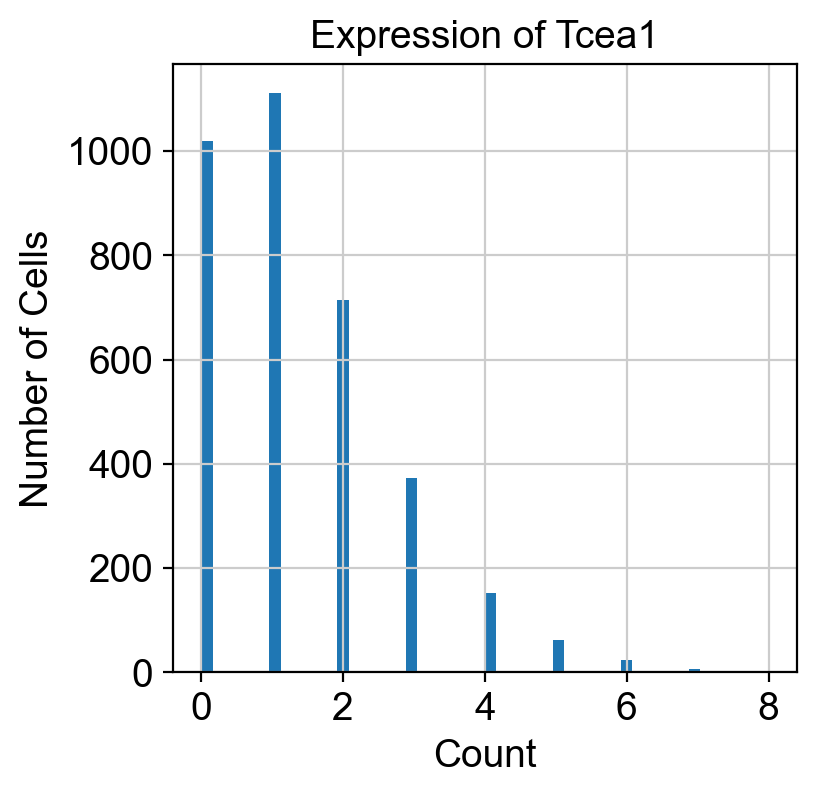

In [113]:
import matplotlib.pyplot as plt

gene = "Tcea1"  # Replace with a gene in your dataset

if gene in df.columns:
    plt.hist(df[gene].astype(float), bins=50)
    plt.title(f"Expression of {gene}")
    plt.xlabel("Count")
    plt.ylabel("Number of Cells")
    plt.show()
else:
    print(f"Gene {gene} not found in dataset.")

In [114]:
from scipy.io import mmread
import numpy as np

# Load sparse matrix
mtx = mmread("matrix.mtx")

# Convert to dense NumPy array if small
dense_mtx = mtx.toarray()

# View first few rows
print(dense_mtx)

[[8 2 2 ... 5 5 0]
 [1 1 1 ... 3 3 0]
 [4 0 1 ... 0 3 2]
 ...
 [1 2 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [2 0 1 ... 0 0 0]]


✅ Loaded data: (2730, 3451) (cells, genes)


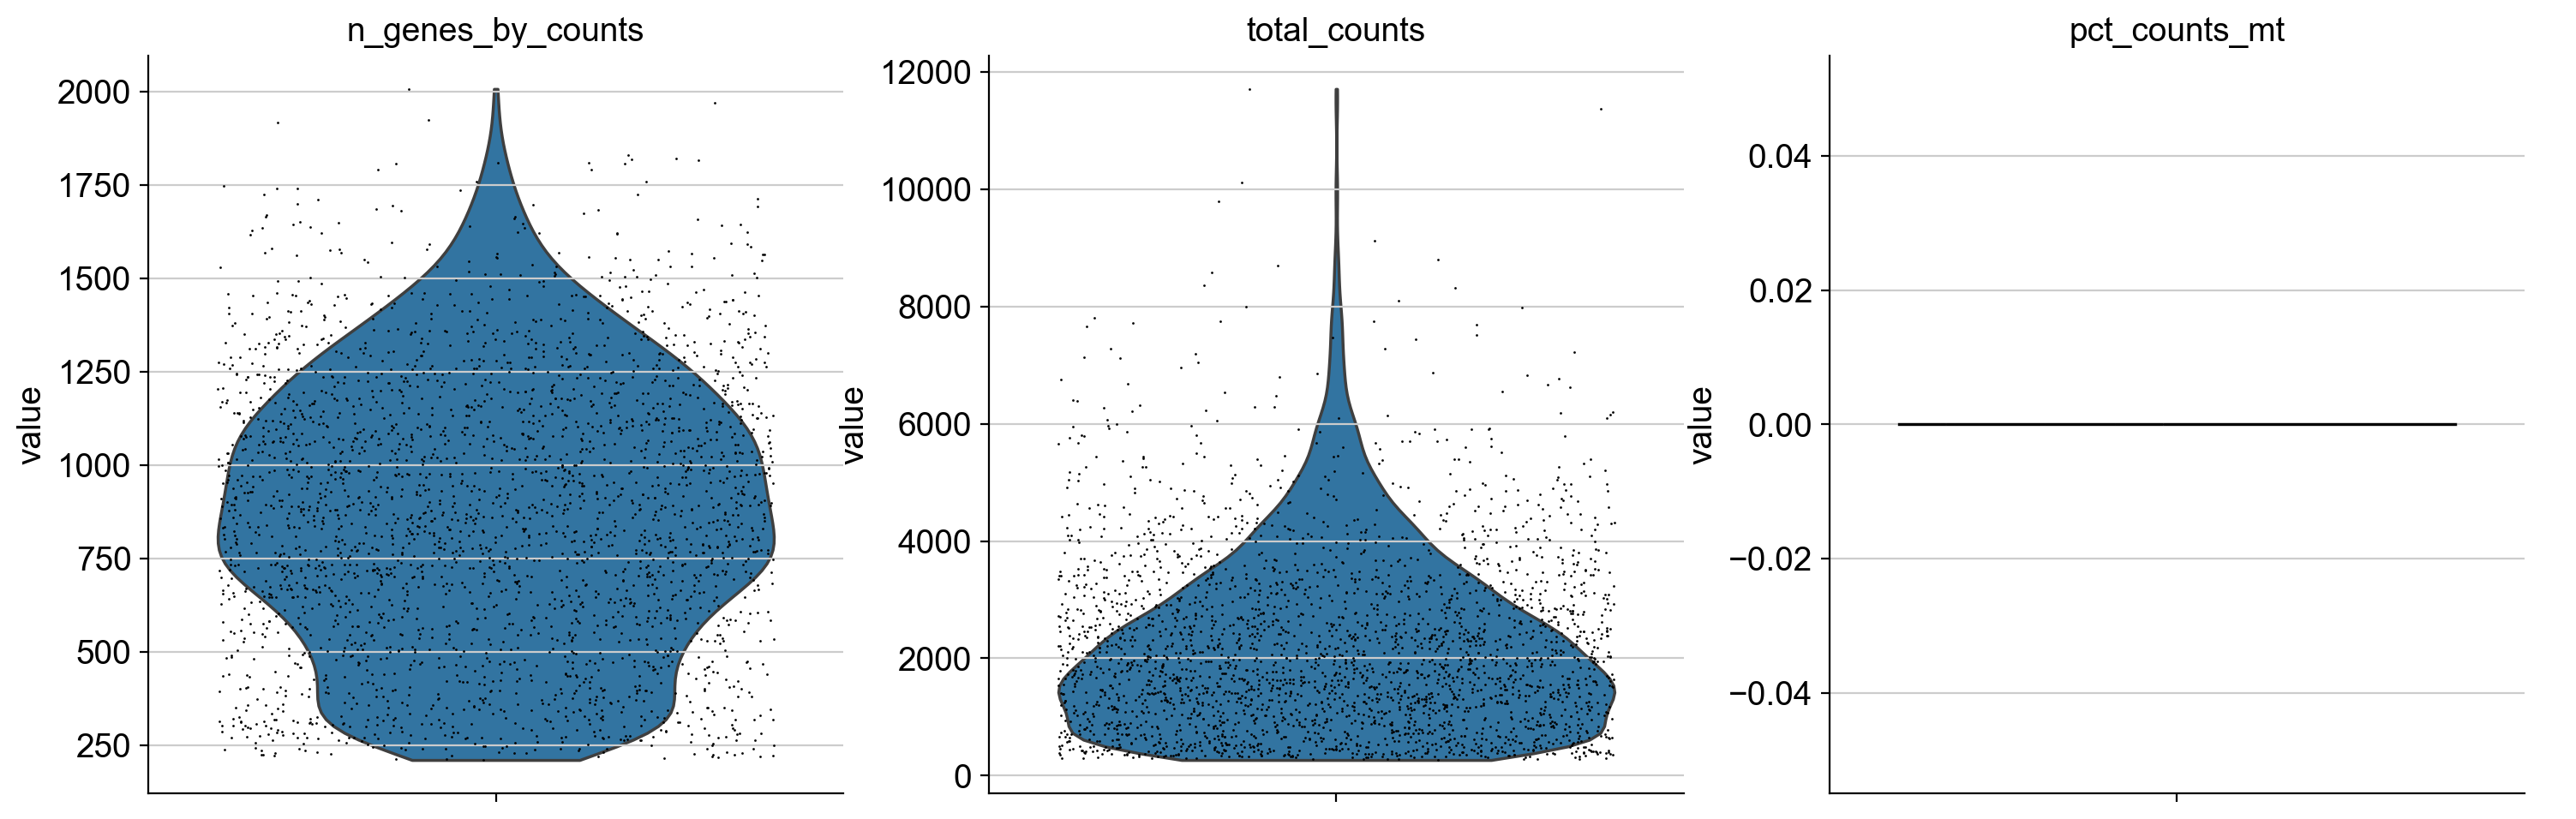

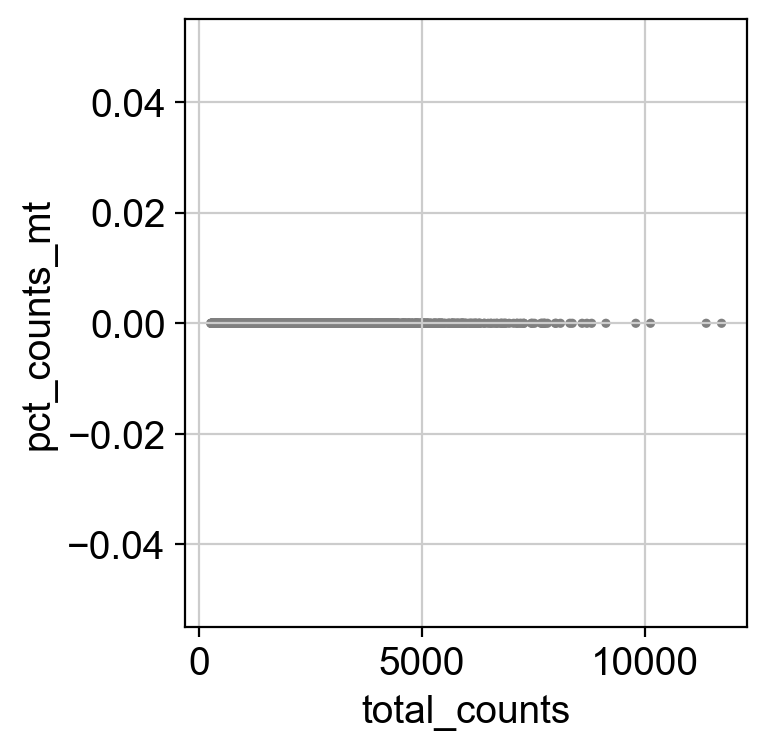

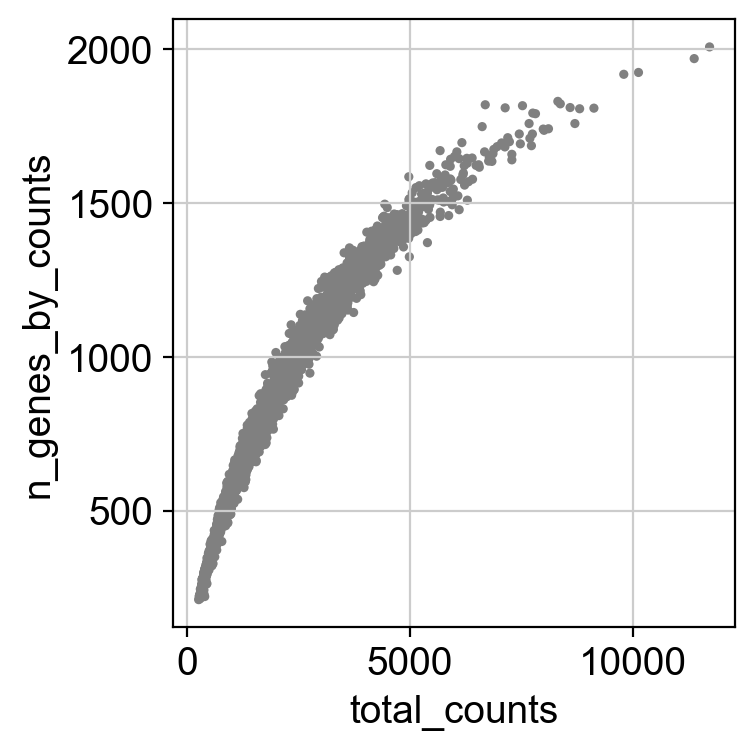

🔎 Before filtering: (2730, 3267)
✅ After filtering: (2589, 3267)


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


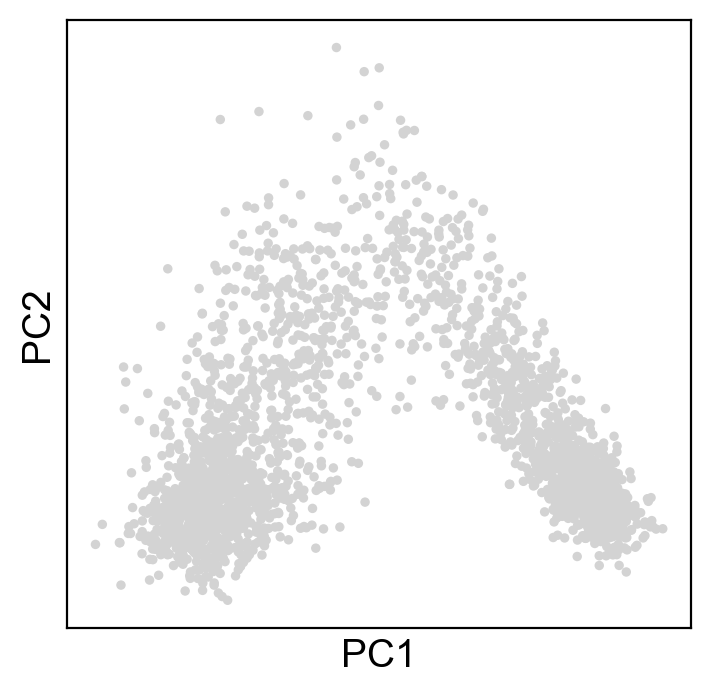

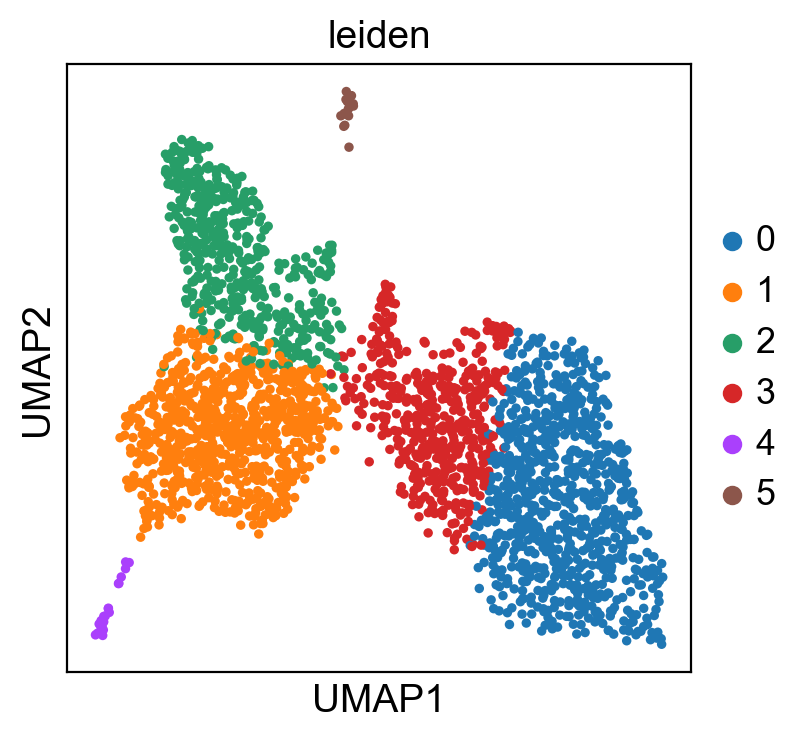

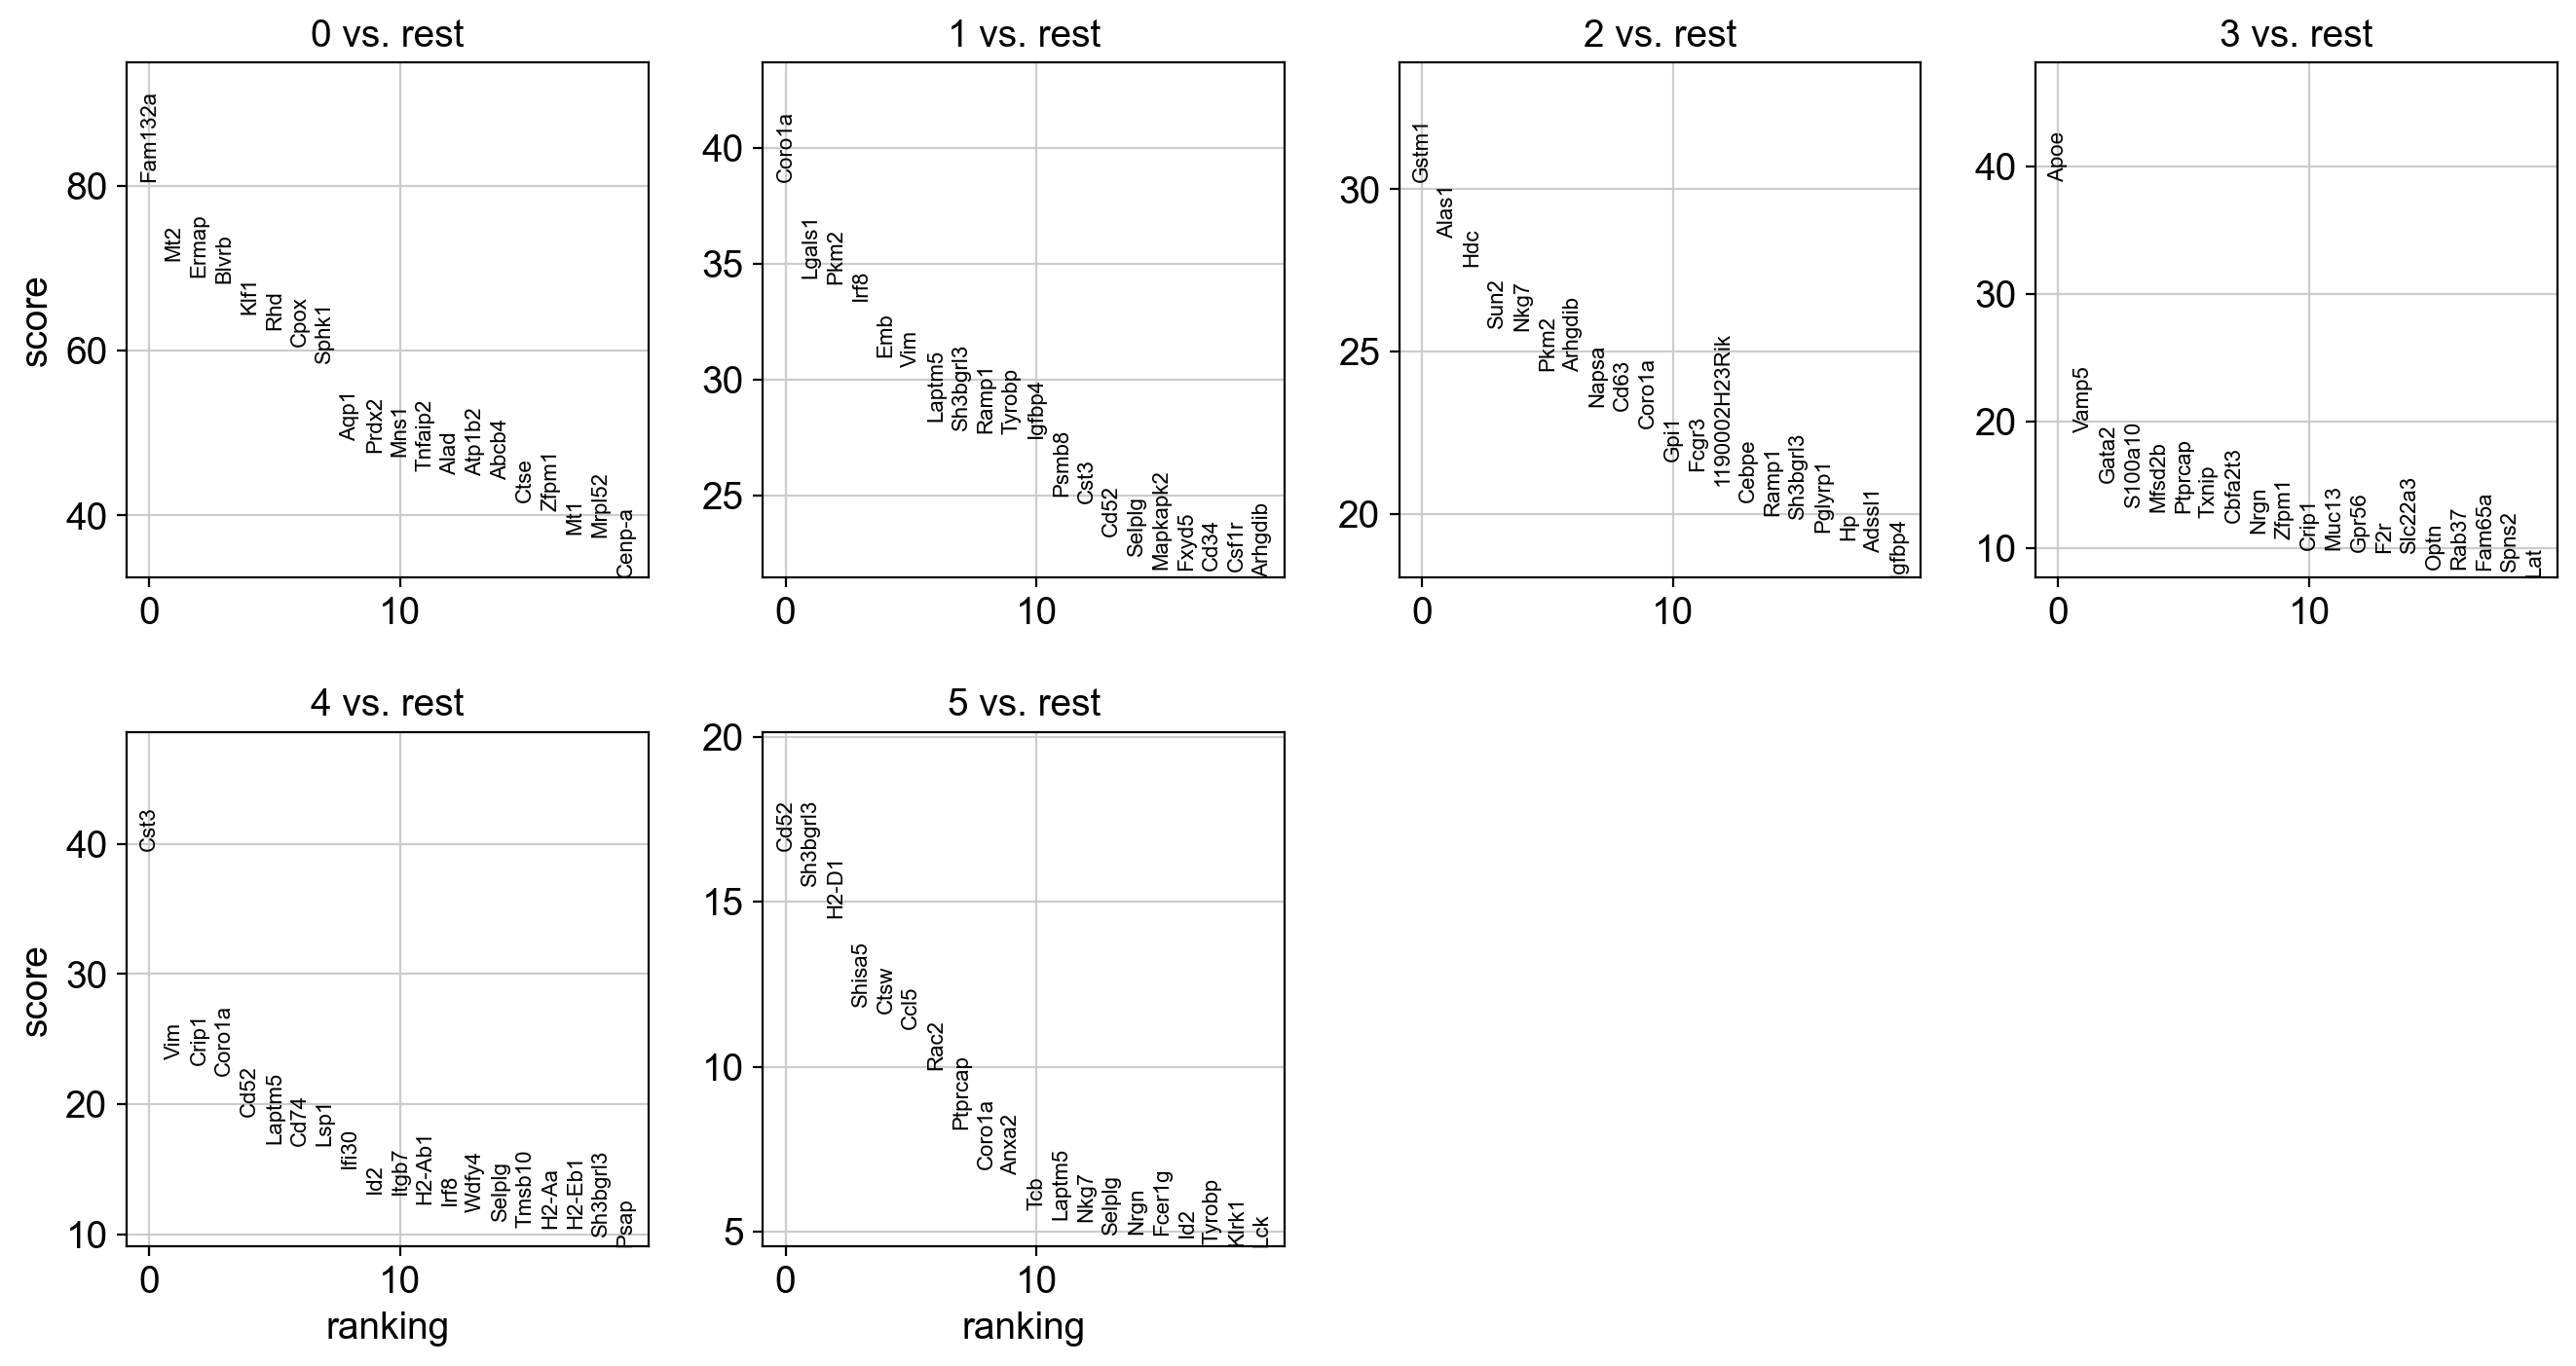

saving figure to file figures/umap_clusters.png


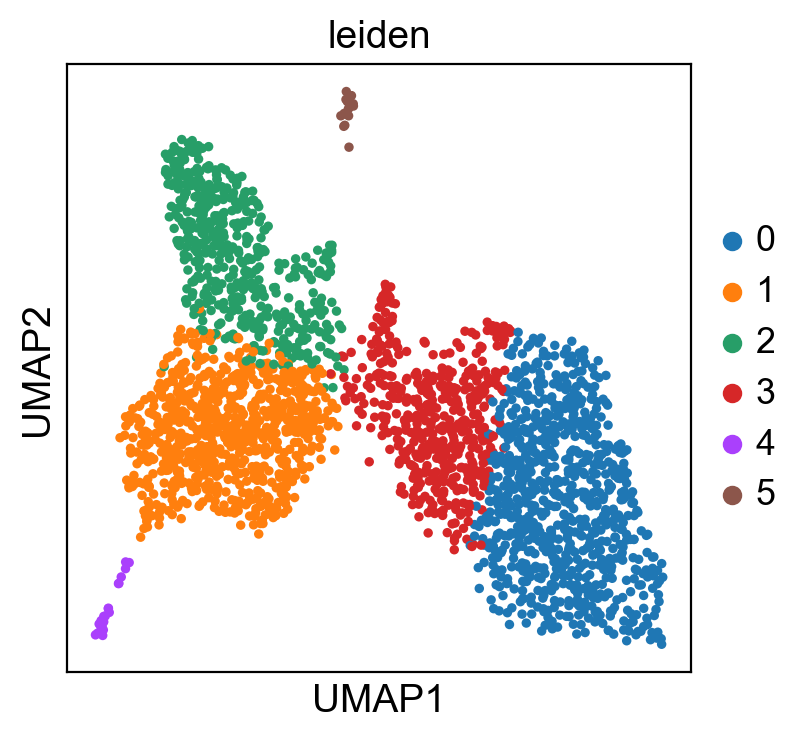

✅ Pipeline complete!
 - processed_data.h5ad
 - marker_genes.csv
 - UMAP plot saved


In [115]:
# 📦 Imports
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────
# 🔧 Scanpy Settings
# ──────────────────────────────────────────────
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, facecolor='white')

# ──────────────────────────────────────────────
# 📁 Load Data
# ──────────────────────────────────────────────
# Example dataset — replace with your actual 10x directory
# data_dir = "path/to/10x_data"
# adata = sc.read_10x_mtx(data_dir, var_names='gene_symbols', cache=True)

adata = sc.datasets.paul15()  # REMOVE this line when using real data
print(f"✅ Loaded data: {adata.shape} (cells, genes)")

# ──────────────────────────────────────────────
# 🧼 Step 1: Basic QC
# ──────────────────────────────────────────────
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=30)

# Annotate mitochondrial genes
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Visualize QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# ──────────────────────────────────────────────
# 🧼 Step 2: Filtering
# ──────────────────────────────────────────────
print("🔎 Before filtering:", adata.shape)

# Adjust thresholds as needed
adata = adata[(adata.obs.n_genes_by_counts < 6000) &
              (adata.obs.n_genes_by_counts > 300) &
              (adata.obs.pct_counts_mt < 20), :]

print("✅ After filtering:", adata.shape)

if adata.n_obs == 0:
    raise ValueError("❌ All cells removed during filtering — adjust thresholds.")

# ──────────────────────────────────────────────
# 🧪 Step 3: Normalize & Log-transform
# ──────────────────────────────────────────────
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ──────────────────────────────────────────────
# 🔍 Step 4: Highly Variable Genes
# ──────────────────────────────────────────────
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)
adata = adata[:, adata.var.highly_variable]

# ──────────────────────────────────────────────
# 🔬 Step 5: Scale & PCA
# ──────────────────────────────────────────────
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

# ──────────────────────────────────────────────
# 🤝 Step 6: Neighbors & UMAP
# ──────────────────────────────────────────────
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# ──────────────────────────────────────────────
# 🔖 Step 7: Clustering
# ──────────────────────────────────────────────
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

# ──────────────────────────────────────────────
# 🧬 Step 8: Marker Gene Discovery
# ──────────────────────────────────────────────
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

marker_df = sc.get.rank_genes_groups_df(adata, group=None)
marker_df.to_csv("marker_genes.csv", index=False)

# ──────────────────────────────────────────────
# 💾 Step 9: Save Results
# ──────────────────────────────────────────────
adata.write("processed_data.h5ad")
sc.pl.umap(adata, color=['leiden'], save="_clusters.png")

print("✅ Pipeline complete!")
print(" - processed_data.h5ad")
print(" - marker_genes.csv")
print(" - UMAP plot saved")


In [116]:
# Step 1: Build graph (Scanpy or custom)
# Step 2: Train GNN to embed state
# Step 3: Create Gym-style environment for cell fate transitions
# Step 4: Train RL agent with GNN-based policy


#scRNA-seq data → Gene Expression Matrix → GRN Inference (SCENIC / GRNBoost)
#         ↓
#    Graph: Genes = nodes, regulation = edges
#         ↓
#    GNN → encodes current cell state from GRN
#         ↓
#RL Agent (PPO, A2C, etc.)
 #        ↓
# Selects action (TF activation, perturbation)
  #       ↓
#Environment simulates cell transition → Next GRN-encoded state


In [149]:
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from gym import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv, VecNormalize
from scipy.sparse import issparse
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import warnings
import time
import os

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ----------------- Repro seeds & device -----------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cpu")  # CPU for multiprocess pickling; change if single-GPU

# ----------------- Config / Hyperparams -----------------
N_GENES_SELECT = 20
GCN_HIDDEN = 64
GCN_EMB = 32
AE_TRAIN_EPOCHS = 1000
SAC_TOTAL_TIMESTEPS = 1000000
SAC_POLICY_ARCH = [256, 256]
SAC_BATCH_SIZE = 128
SAC_BUFFER = int(1e6)
LEARNING_STARTS = 1000

# ----------------- Adaptive Threshold Class -----------------
class PerGeneAdaptiveThreshold:
    def __init__(self, gene_list, alpha=0.1):
        self.thresholds = {int(g): 0.0 for g in gene_list}
        self.alpha = alpha
    def update(self, gene_rewards):
        for gene_id, reward in gene_rewards.items():
            if reward is None or (isinstance(reward, float) and np.isnan(reward)):
                continue
            gid = int(gene_id)
            prev = self.thresholds.get(gid, 0.0)
            self.thresholds[gid] = self.alpha * float(reward) + (1 - self.alpha) * prev
    def get(self, gene_id):
        return float(self.thresholds.get(int(gene_id), 0.0))

# ----------------- Step 1: Load & preprocess data -----------------
#adata = sc.datasets.paul15()
#adata = sc.datasets.moignard15()
#adata = sc.datasets.visium_sge()

adata = sc.read_10x_mtx("Untitled Folder 3/")

sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=500)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, inplace=True)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata)

# ----------------- Step 2: Pseudotime inference -----------------
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.diffmap(adata)
adata.uns['iroot'] = 0
sc.tl.dpt(adata)
pseudotime = adata.obs['dpt_pseudotime'].values

# ----------------- Step 3: Gene selection -----------------
X_full = adata.X.toarray() if issparse(adata.X) else np.asarray(adata.X)
y = pseudotime
mi_scores = mutual_info_regression(X_full, y, discrete_features=False, random_state=SEED)
N = min(N_GENES_SELECT, X_full.shape[1])
top_gene_indices = np.argsort(mi_scores)[-N:]
X = X_full[:, top_gene_indices].astype(np.float32)
adata = adata[:, top_gene_indices]
selected_gene_names = list(adata.var_names)

# ----------------- Step 4: Train/test split and normalization -----------------
n_cells, n_genes = X.shape
indices = np.arange(n_cells)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=SEED, shuffle=True)
expression_train = X[train_idx]
expression_test = X[test_idx]
pseudotime_train = pseudotime[train_idx]
pseudotime_test = pseudotime[test_idx]
gene_means = expression_train.mean(axis=0)
gene_stds = expression_train.std(axis=0) + 1e-8
expression_train = (expression_train - gene_means) / gene_stds
expression_test = (expression_test - gene_means) / gene_stds
X = np.vstack([expression_train, expression_test])

# ----------------- Step 5: Adjacency matrix -----------------
X_full_selected = X_full[:, top_gene_indices]
peak_pt = np.zeros(n_genes, dtype=float)
order = np.argsort(pseudotime)
for g in range(n_genes):
    vals = X_full_selected[order, g]
    peak_idx = int(np.nanargmax(vals))
    peak_pt[g] = pseudotime[order][peak_idx]
corr_matrix = np.corrcoef(np.vstack([expression_train, expression_test]).T)
adj_matrix = np.zeros_like(corr_matrix)
corr_threshold = 0.1
for i in range(n_genes):
    for j in range(n_genes):
        if i == j:
            continue
        if peak_pt[i] < peak_pt[j] and abs(corr_matrix[i, j]) >= corr_threshold:
            adj_matrix[i, j] = float(corr_matrix[i, j])
adj_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
edge_index, edge_weight = dense_to_sparse(adj_tensor)
edge_index = edge_index.long().cpu()
edge_weight = edge_weight.float().cpu()

# ----------------- Step 6: GCN Autoencoder -----------------
class GCN_AE(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=GCN_HIDDEN, emb_dim=GCN_EMB):
        super().__init__()
        self.enc1 = GCNConv(in_dim, hidden_dim)
        self.enc2 = GCNConv(hidden_dim, emb_dim)
        self.dec = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )
    def forward(self, x, edge_index):
        x = self.enc1(x, edge_index)
        x = F.relu(x)
        emb = self.enc2(x, edge_index)
        recon = self.dec(emb)
        return recon, emb

mean_expr = np.mean(expression_train, axis=0).reshape(-1, 1).astype(np.float32)
x_input = torch.tensor(mean_expr)
gcn_ae = GCN_AE(in_dim=1).to(DEVICE)
opt = torch.optim.Adam(gcn_ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()
gcn_ae.train()
print("\n--- Pretraining GCN-AE ---")
for epoch in range(AE_TRAIN_EPOCHS):
    opt.zero_grad()
    recon, emb = gcn_ae(x_input.to(DEVICE), edge_index.to(DEVICE))
    loss = loss_fn(recon.squeeze(), x_input.squeeze())
    loss.backward()
    opt.step()
    if (epoch + 1) % 50 == 0:
        print(f"AE epoch {epoch+1}/{AE_TRAIN_EPOCHS} loss {loss.item():.6f}")
torch.save(gcn_ae.state_dict(), "gcn_ae.pth")
gcn_ae.eval()

# ----------------- Step 7: GCN Encoder -----------------
class GeneGCN_Encoder(nn.Module):
    def __init__(self, gcn_ae):
        super().__init__()
        self.enc1 = gcn_ae.enc1
        self.enc2 = gcn_ae.enc2
    def forward(self, x, edge_index):
        x = self.enc1(x, edge_index)
        x = F.relu(x)
        emb = self.enc2(x, edge_index)
        return emb

encoder = GeneGCN_Encoder(gcn_ae).to(DEVICE)
encoder.eval()
torch.save(encoder.state_dict(), "gcn_encoder.pth")

# ----------------- Step 8: Dynamics Model -----------------
class DynamicsModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim),
        )
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)

# TODO: Train your dynamics model here with your data!
dynamics_model = DynamicsModel(state_dim=n_genes, action_dim=n_genes)
# e.g. dynamics_model.load_state_dict(torch.load("dynamics_model.pth"))
dynamics_model.to(DEVICE).eval()

# ----------------- Step 9: Model-based Environment -----------------
class GRNEnvModelBased(gym.Env):
    metadata = {"render_modes": ["human"]}
    def __init__(self, expression, adj_matrix, pseudotime, edge_index, edge_weight=None,
                 encoder_path="gcn_encoder.pth", max_steps=50, adaptive_thresholds=None,
                 dynamics_model=None, device='cpu'):
        super().__init__()
        self.expression = np.asarray(expression).astype(np.float32)
        self.adj_matrix = np.asarray(adj_matrix).astype(np.float32)
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.pseudotime = np.asarray(pseudotime).astype(np.float32)
        self.n_cells, self.n_genes = self.expression.shape
        self.max_steps = max_steps
        self.adaptive_thresholds = adaptive_thresholds
        self.device = device

        self.encoder = GeneGCN_Encoder(gcn_ae).to(device)
        if os.path.exists(encoder_path):
            try:
                self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))
            except Exception:
                pass
        self.encoder.eval()

        assert dynamics_model is not None, "Provide pretrained dynamics model"
        self.dynamics_model = dynamics_model.to(device)
        self.dynamics_model.eval()

        self.obs_dim = GCN_EMB
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_genes, self.obs_dim), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self.n_genes,), dtype=np.float32)
        self.steps = 0

    def reset(self, seed=None, options=None):
        self.idx = np.random.randint(self.n_cells)
        self.current_cell = int(self.idx)
        self.state = self.expression[self.idx].copy()
        self.original_state = self.state.copy()
        eligible_idxs = np.where(self.pseudotime > self.pseudotime[self.idx])[0]
        if len(eligible_idxs) == 0:
            eligible_idxs = np.array([self.idx])
        target_idx = np.random.choice(eligible_idxs)
        self.target = self.expression[target_idx].copy()
        self.reward_gene = int(np.random.randint(self.n_genes))
        self.target_value = float(self.target[self.reward_gene])
        self.steps = 0
        self.history = [self.state.copy()]
        self.knockout_genes = set()
        self.overexpressed_genes = set()
        return self._get_observation().astype(np.float32), {}

    def _get_observation(self):
        x = torch.tensor(self.state, dtype=torch.float32).view(-1,1).to(self.device)
        with torch.no_grad():
            emb = self.encoder(x, self.edge_index.to(self.device)).cpu().numpy()
        return emb

    def step(self, action):
        action = np.clip(np.asarray(action).flatten(), -1.0, 1.0)
        scale = 0.25
        state_tensor = torch.tensor(self.state, dtype=torch.float32).to(self.device).unsqueeze(0)
        action_tensor = torch.tensor(scale * action * (1.0 + np.abs(self.state)), dtype=torch.float32).to(self.device).unsqueeze(0)
        with torch.no_grad():
            next_state = self.dynamics_model(state_tensor, action_tensor).squeeze(0).cpu().numpy()
        self.state = np.clip(next_state, -5.0, 5.0)
        old_mse = float(np.mean((self.history[-1] - self.target)**2)) if len(self.history)>0 else float(np.mean((self.original_state - self.target)**2))
        new_mse = float(np.mean((self.state - self.target)**2))
        reward = old_mse - new_mse
        gene_improvement = (abs(self.original_state[self.reward_gene] - self.target[self.reward_gene])
                            - abs(self.state[self.reward_gene] - self.target[self.reward_gene]))
        reward += 0.2 * float(gene_improvement)
        if self.adaptive_thresholds:
            threshold = self.adaptive_thresholds.get(self.reward_gene)
            reward -= threshold
        self.steps += 1
        self.history.append(self.state.copy())
        terminated = self.steps >= self.max_steps
        truncated = False
        info = {"old_mse": old_mse, "new_mse": new_mse, "reward_gene": int(self.reward_gene)}
        return self._get_observation().astype(np.float32), float(reward), terminated, truncated, info

    def render(self, mode='human'):
        print(f"Step {self.steps} - gene {self.reward_gene} value {self.state[self.reward_gene]:.4f}")
        print(f"Knockouts: {sorted(list(self.knockout_genes))}, Overexpressed: {sorted(list(self.overexpressed_genes))}")



/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca



--- Pretraining GCN-AE ---
AE epoch 50/1000 loss 0.000000
AE epoch 100/1000 loss 0.000000
AE epoch 150/1000 loss 0.000000
AE epoch 200/1000 loss 0.000000
AE epoch 250/1000 loss 0.000000
AE epoch 300/1000 loss 0.000000
AE epoch 350/1000 loss 0.000000
AE epoch 400/1000 loss 0.000000
AE epoch 450/1000 loss 0.000000
AE epoch 500/1000 loss 0.000000
AE epoch 550/1000 loss 0.000000
AE epoch 600/1000 loss 0.000000
AE epoch 650/1000 loss 0.000000
AE epoch 700/1000 loss 0.000000
AE epoch 750/1000 loss 0.000000
AE epoch 800/1000 loss 0.000000
AE epoch 850/1000 loss 0.000000
AE epoch 900/1000 loss 0.000000
AE epoch 950/1000 loss 0.000000
AE epoch 1000/1000 loss 0.000000


In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from dtaidistance import dtw
from scipy.interpolate import interp1d

def resample_sequence(seq, target_len):
    seq = np.asarray(seq)
    orig_len = len(seq)
    if orig_len == target_len:
        return seq
    x_old = np.linspace(0, 1, orig_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, seq, kind='linear')
    return f(x_new)

def evaluate_and_plot(model, algo_name, expression_test, adj_matrix, pseudotime_test,
                      gene_names, edge_index, edge_weight, encoder_path,
                      adaptive_thresholds, dynamics_model, n_episodes=50):

    results = []
    eval_env_factory = make_env_factory(expression_test, adj_matrix, pseudotime_test,
                                        edge_index, edge_weight, encoder_path,
                                        adaptive_thresholds, dynamics_model)

    for gene_idx, gene_name in enumerate(gene_names):
        y_true, y_pred = [], []
        perturbed_vals, original_vals, pseudotimes = [], [], []

        all_trajs_pred = []
        all_trajs_true = []

        for ep in range(n_episodes):
            env = eval_env_factory()
            reset_result = env.reset()
            obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result

            original = env.original_state.copy()
            target = env.target.copy()
            pt_value = float(env.pseudotime[env.current_cell])

            done = False
            traj_pred = []

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                step_result = env.step(action)
                if len(step_result) == 5:
                    obs, reward, terminated, truncated, info = step_result
                    done = terminated or truncated
                else:
                    obs, reward, done, info = step_result

                traj_pred.append(env.state[gene_idx])

            final_state = env.history[-1]
            delta = float(final_state[gene_idx] - original[gene_idx])
            label = 1 if target[gene_idx] > original[gene_idx] else 0
            prediction = 1 if delta > 0 else 0

            y_true.append(label)
            y_pred.append(prediction)
            perturbed_vals.append(float(final_state[gene_idx]))
            original_vals.append(float(original[gene_idx]))
            pseudotimes.append(pt_value)

            all_trajs_pred.append(np.array(traj_pred))
            if hasattr(env, 'true_trajectory') and env.true_trajectory is not None:
                true_traj_full = np.array(env.true_trajectory)
                true_traj_gene = true_traj_full[:, gene_idx]
                all_trajs_true.append(true_traj_gene)
            else:
                all_trajs_true.append(np.array([target[gene_idx]] * len(traj_pred)))

        # Classification metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        # Final expression metrics
        mse = mean_squared_error(original_vals, perturbed_vals)
        corr = np.corrcoef(original_vals, perturbed_vals)[0, 1]

        # Trajectory DTW and correlation
        dtw_distances = []
        traj_corrs = []

        for pred_traj, true_traj in zip(all_trajs_pred, all_trajs_true):
            pred_traj_1d = np.asarray(pred_traj).flatten()
            true_traj_1d = np.asarray(true_traj).flatten()

            if len(pred_traj_1d) < 2 or len(true_traj_1d) < 2:
                traj_corrs.append(np.nan)
                continue

            target_len = min(len(pred_traj_1d), len(true_traj_1d))
            pred_resampled = resample_sequence(pred_traj_1d, target_len)
            true_resampled = resample_sequence(true_traj_1d, target_len)

            dtw_distances.append(dtw.distance(pred_resampled, true_resampled))

            try:
                if np.std(pred_resampled) == 0 or np.std(true_resampled) == 0:
                    corr_val = np.nan
                else:
                    corr_val = np.corrcoef(pred_resampled, true_resampled)[0, 1]
            except Exception:
                corr_val = np.nan

            traj_corrs.append(corr_val)

        avg_dtw = np.mean(dtw_distances) if dtw_distances else np.nan
        avg_traj_corr = np.nanmean(traj_corrs) if traj_corrs else np.nan

        results.append({
            "Algorithm": algo_name,
            "Gene": gene_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "Final Expression MSE": mse,
            "Final Expression Correlation": corr,
            "Trajectory DTW": avg_dtw,
            "Trajectory Correlation": avg_traj_corr
        })

        # Plot pseudotime perturbation
        df = pd.DataFrame({
            "pseudotime": pseudotimes,
            "original_expression": original_vals,
            "perturbed_expression": perturbed_vals
        })
        df['delta'] = df['perturbed_expression'] - df['original_expression']
        df['label'] = df['delta'].apply(lambda x: "Up" if x > 0 else "Down")

        plt.figure(figsize=(8, 4))
        sns.scatterplot(data=df, x="pseudotime", y="perturbed_expression", hue="label", style="label")
        sns.lineplot(data=df.sort_values('pseudotime'),
                     x="pseudotime", y="perturbed_expression",
                     lw=1, alpha=0.5, label="Mean trajectory")
        plt.title(f"{algo_name} — {gene_name} Perturbation")
        plt.xlabel("Pseudotime")
        plt.ylabel("Expression (z-score)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"pseudotime_plots/{algo_name}_{gene_name}.png", dpi=300)
        plt.close()

    return pd.DataFrame(results)


# -----------------------------------
# Training & evaluation loop with comparison
# -----------------------------------

results_reward = {}
trained_models = {}

eval_env = DummyVecEnv([env_fn])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)

# Train each algorithm
for name in ["A2C", "TRPO", "PPO", "SAC"]:
    print(f"\n--- Training {name} ---")
    env_instance = DummyVecEnv([env_fn])
    model = algorithms[name]["class"]("MlpPolicy", env_instance, verbose=0, seed=SEED, **algorithms[name]["kwargs"])
    start = time.time()
    model.learn(total_timesteps=train_steps[name])
    print(f"{name} training finished in {(time.time()-start)/60:.2f} min")

    trained_models[name] = model
    mean_r, std_r = evaluate_model(model, eval_env)
    results_reward[name] = (mean_r, std_r)

# Multi-stage: TRPO → PPO
print("\n--- Multi-stage: TRPO then PPO ---")
env_instance = DummyVecEnv([env_fn])
trpo_model = algorithms["TRPO_from_PPO"]["class"]("MlpPolicy", env_instance, verbose=0, seed=SEED)
start = time.time()
trpo_model.learn(total_timesteps=train_steps["TRPO_from_PPO"])

ppo_from_trpo = algorithms["TRPO_to_PPO"]["class"]("MlpPolicy", env_instance, verbose=0, seed=SEED)
ppo_from_trpo.policy.load_state_dict(trpo_model.policy.state_dict())
ppo_from_trpo.learn(total_timesteps=train_steps["TRPO_to_PPO"])
print(f"PPO from TRPO training finished in {(time.time()-start)/60:.2f} min")

trained_models["PPO_from_TRPO"] = ppo_from_trpo
mean_r, std_r = evaluate_model(ppo_from_trpo, eval_env)
results_reward["PPO_from_TRPO"] = (mean_r, std_r)

# Save reward summary
df_rewards = pd.DataFrame(results_reward, index=["mean_reward", "std_reward"]).T
df_rewards.to_csv("reward_summary.csv")
print("\nReward summary:\n", df_rewards)

# Per-gene evaluation for all algorithms with new metrics
all_metrics_df = []
for algo_name, model in trained_models.items():
    print(f"\n--- Evaluating per-gene metrics for {algo_name} ---")
    algo_metrics = evaluate_and_plot(
        model=model,
        algo_name=algo_name,
        expression_test=expression_test,
        adj_matrix=adj_matrix,
        pseudotime_test=pseudotime_test,
        gene_names=selected_gene_names,
        edge_index=edge_index,
        edge_weight=edge_weight,
        encoder_path="gcn_encoder.pth",
        adaptive_thresholds=adaptive_thresholds,
        dynamics_model=dynamics_model,
        n_episodes=200
    )
    all_metrics_df.append(algo_metrics)

final_df = pd.concat(all_metrics_df, ignore_index=True)
final_df.to_csv("per_gene_metrics.csv", index=False)

summary_df = final_df.groupby("Algorithm").mean(numeric_only=True)
summary_df.to_csv("overall_metrics.csv")

print("\n✅ Pseudotime plots saved in pseudotime_plots/")
print("✅ Per-gene metrics saved to per_gene_metrics.csv")
print("✅ Overall metrics saved to overall_metrics.csv")


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- Training A2C ---
A2C training finished in 0.51 min

--- Training TRPO ---
TRPO training finished in 0.37 min

--- Training PPO ---
PPO training finished in 0.48 min

--- Training SAC ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.21GB > 4.58GB
  warnings.warn(


SAC training finished in 5.67 min

--- Multi-stage: TRPO then PPO ---
PPO from TRPO training finished in 0.47 min

Reward summary:
                mean_reward  std_reward
A2C               1.074128    1.541170
TRPO              1.617109    9.935447
PPO               1.997426    5.446264
SAC               1.852809   10.099502
PPO_from_TRPO     1.027557    7.018197

--- Evaluating per-gene metrics for A2C ---

--- Evaluating per-gene metrics for TRPO ---

--- Evaluating per-gene metrics for PPO ---

--- Evaluating per-gene metrics for SAC ---

--- Evaluating per-gene metrics for PPO_from_TRPO ---

✅ Pseudotime plots saved in pseudotime_plots/
✅ Per-gene metrics saved to per_gene_metrics.csv
✅ Overall metrics saved to overall_metrics.csv



--- Evaluation for Gene 0 (Mrpl15) ---
Accuracy:               0.7400
Precision:              0.7474
Recall:                 0.7400
F1 Score:               0.7419
Final Expression MSE:   1.0766
Final Expression Corr:  0.0099
Trajectory DTW:         6.4739
Trajectory Correlation: nan


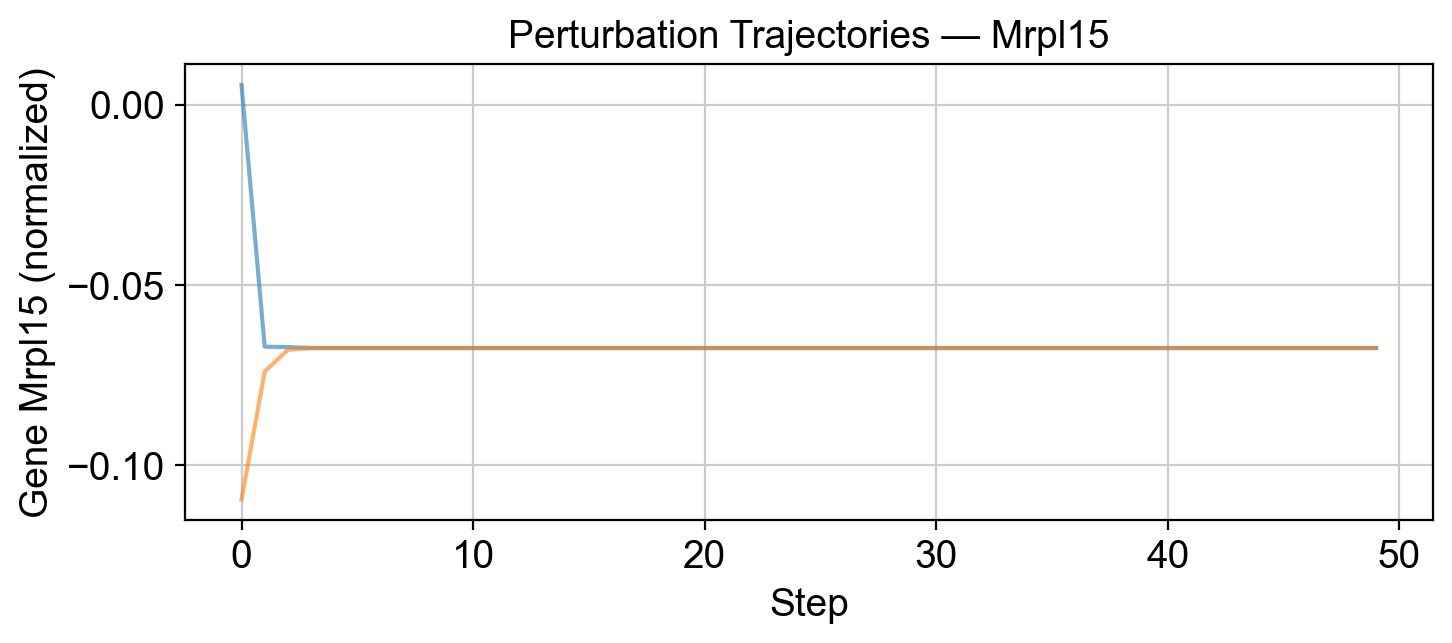


--- Evaluation for Gene 1 (Lypla1) ---
Accuracy:               0.6600
Precision:              0.6989
Recall:                 0.6600
F1 Score:               0.6718
Final Expression MSE:   1.0079
Final Expression Corr:  0.0077
Trajectory DTW:         6.4009
Trajectory Correlation: nan


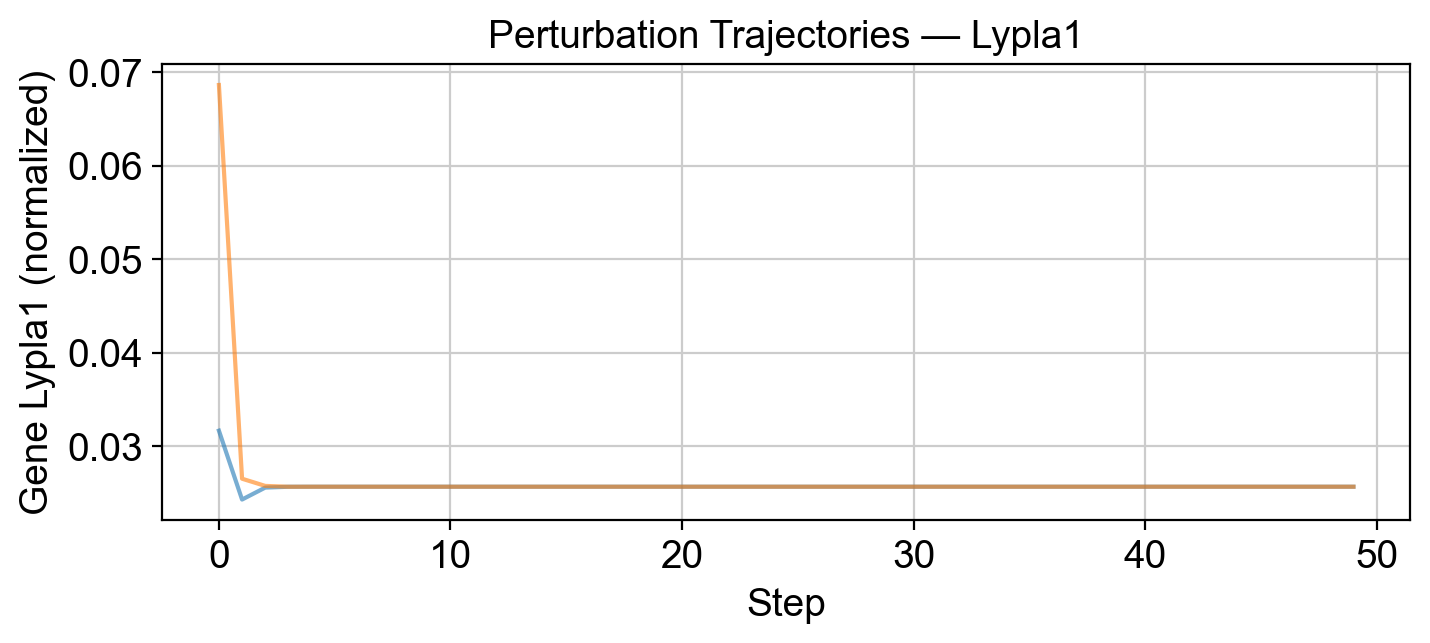


--- Evaluation for Gene 2 (Tcea1) ---
Accuracy:               0.5350
Precision:              0.8237
Recall:                 0.5350
F1 Score:               0.5570
Final Expression MSE:   1.0965
Final Expression Corr:  -0.1634
Trajectory DTW:         5.1197
Trajectory Correlation: nan


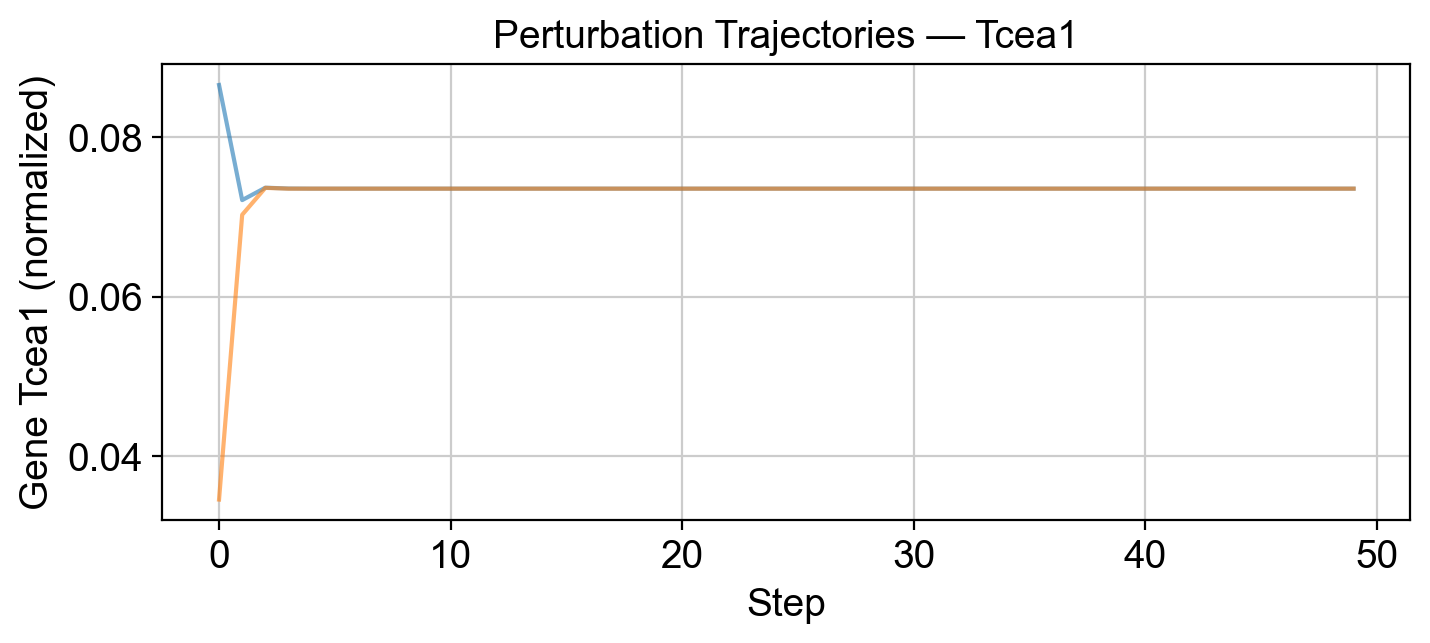


--- Evaluation for Gene 3 (Atp6v1h) ---
Accuracy:               0.7000
Precision:              0.6966
Recall:                 0.7000
F1 Score:               0.6980
Final Expression MSE:   0.9570
Final Expression Corr:  -0.0965
Trajectory DTW:         6.8659
Trajectory Correlation: nan


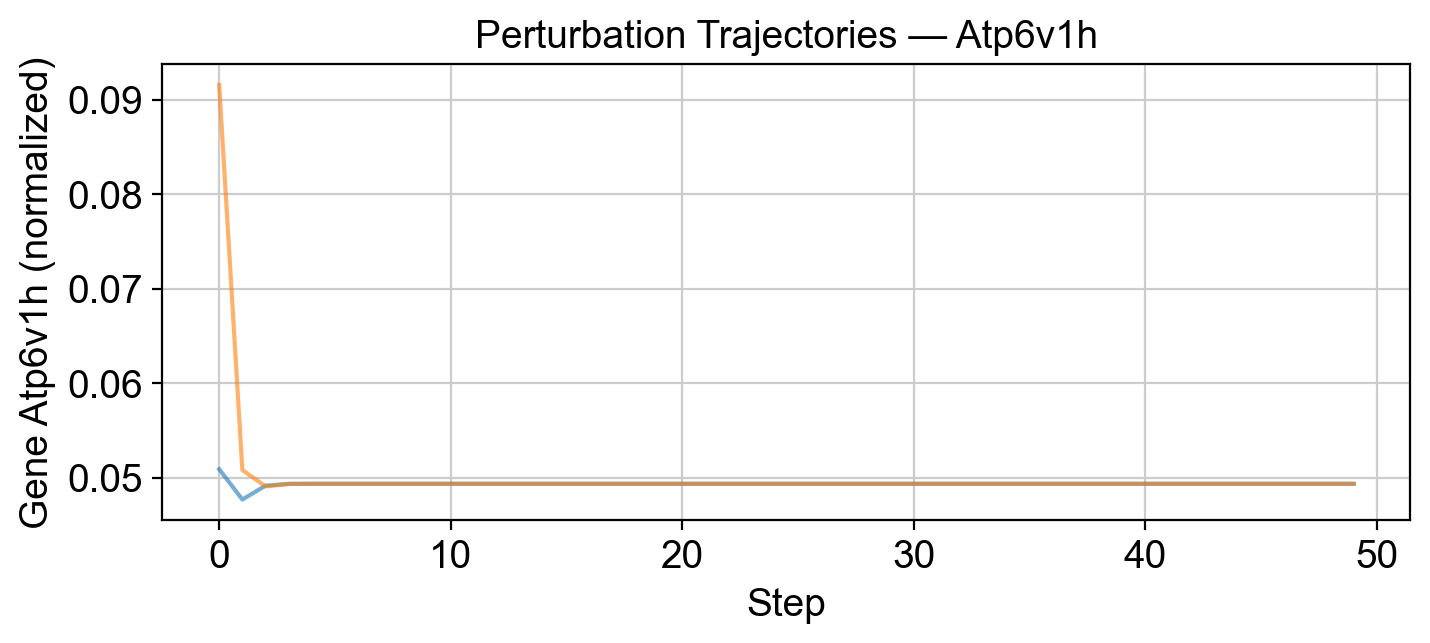


--- Evaluation for Gene 4 (Rb1cc1) ---
Accuracy:               0.7000
Precision:              0.7635
Recall:                 0.7000
F1 Score:               0.7063
Final Expression MSE:   1.1025
Final Expression Corr:  0.0303
Trajectory DTW:         7.3690
Trajectory Correlation: nan


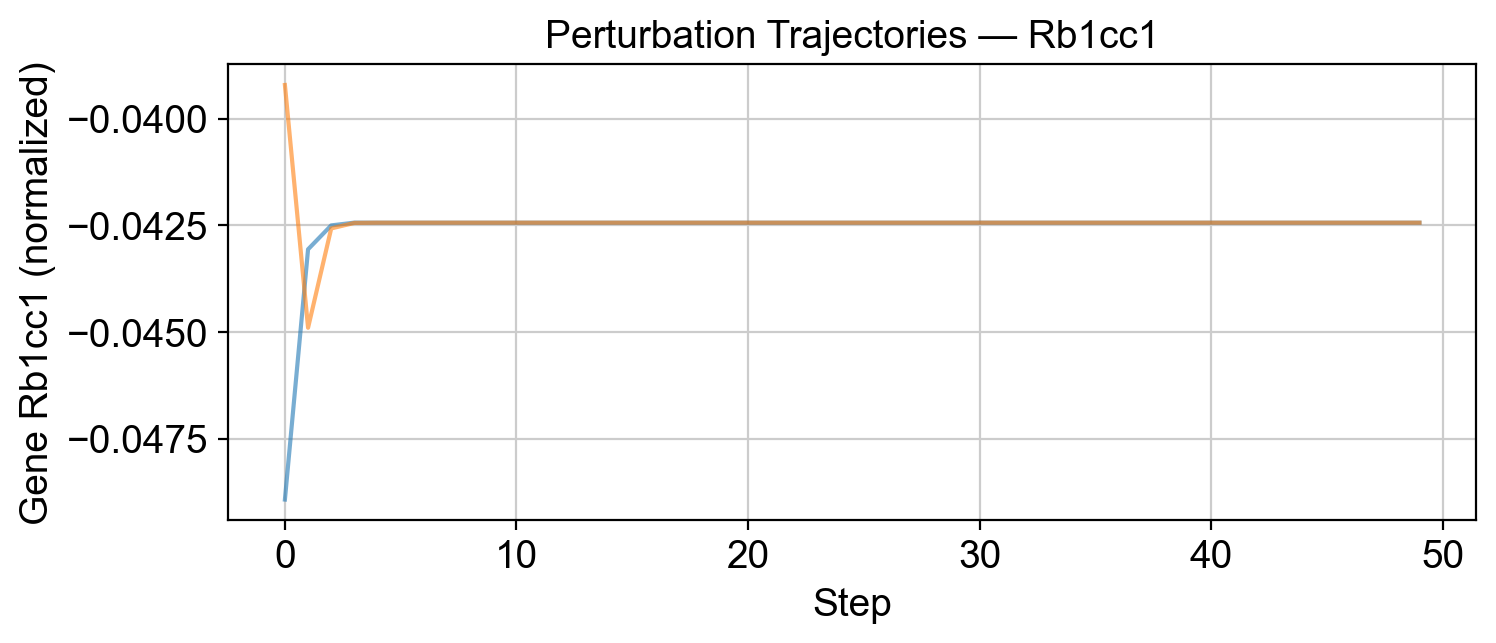


--- Evaluation for Gene 5 (4732440D04Rik) ---
Accuracy:               0.6850
Precision:              0.7344
Recall:                 0.6850
F1 Score:               0.6911
Final Expression MSE:   0.9130
Final Expression Corr:  -0.0349
Trajectory DTW:         5.5481
Trajectory Correlation: nan


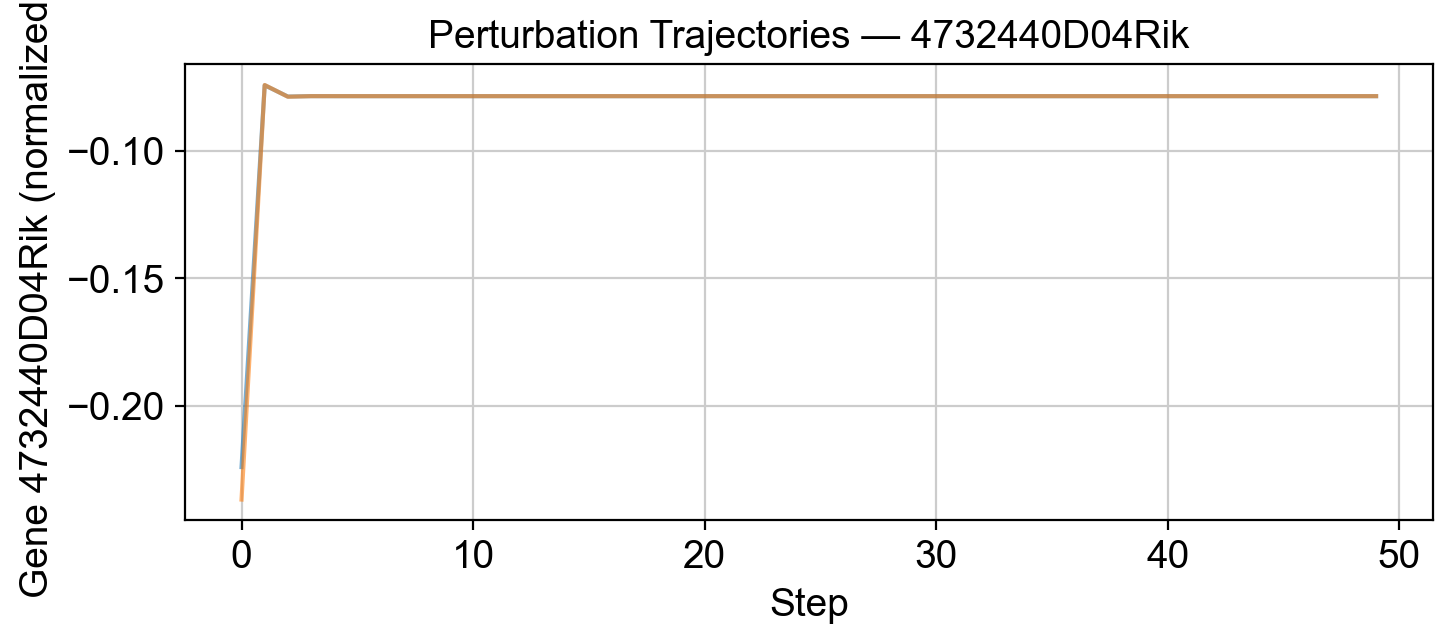


--- Evaluation for Gene 6 (Pcmtd1) ---
Accuracy:               0.6500
Precision:              0.7184
Recall:                 0.6500
F1 Score:               0.6384
Final Expression MSE:   0.8667
Final Expression Corr:  -0.0131
Trajectory DTW:         4.8449
Trajectory Correlation: nan


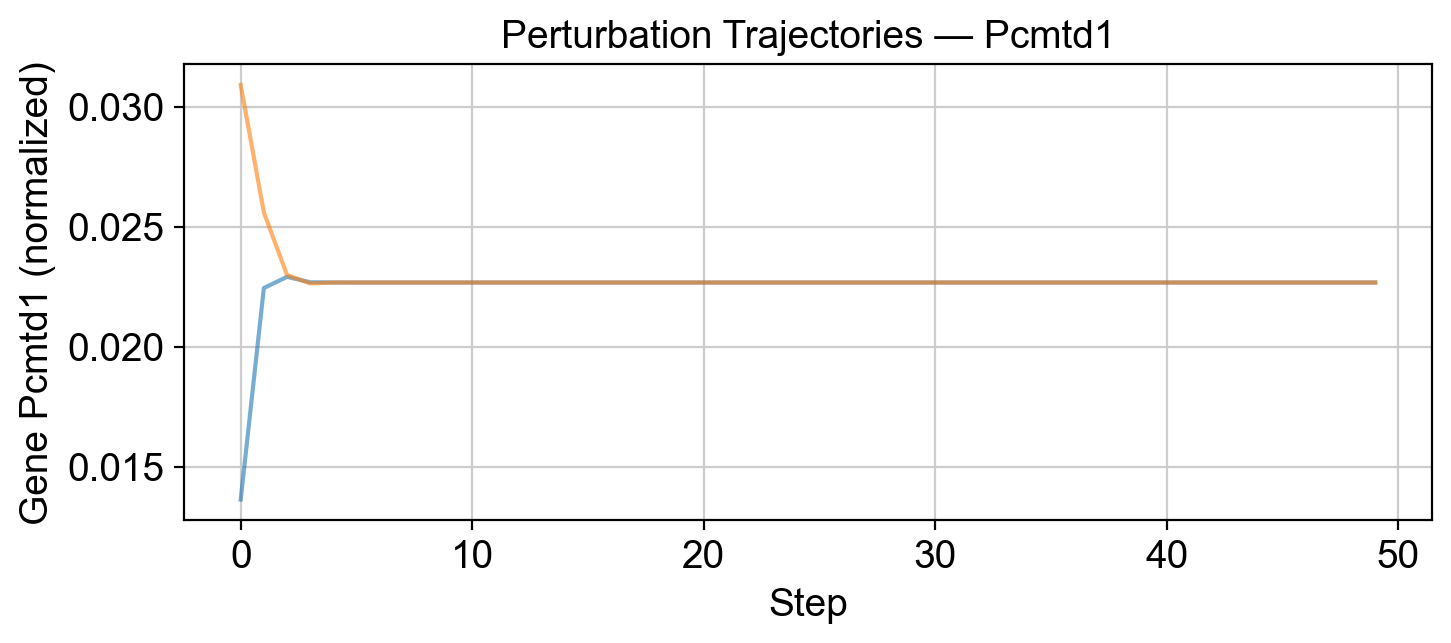


--- Evaluation for Gene 7 (Rrs1) ---
Accuracy:               0.5850
Precision:              0.7884
Recall:                 0.5850
F1 Score:               0.6027
Final Expression MSE:   1.0883
Final Expression Corr:  0.0758
Trajectory DTW:         3.9984
Trajectory Correlation: nan


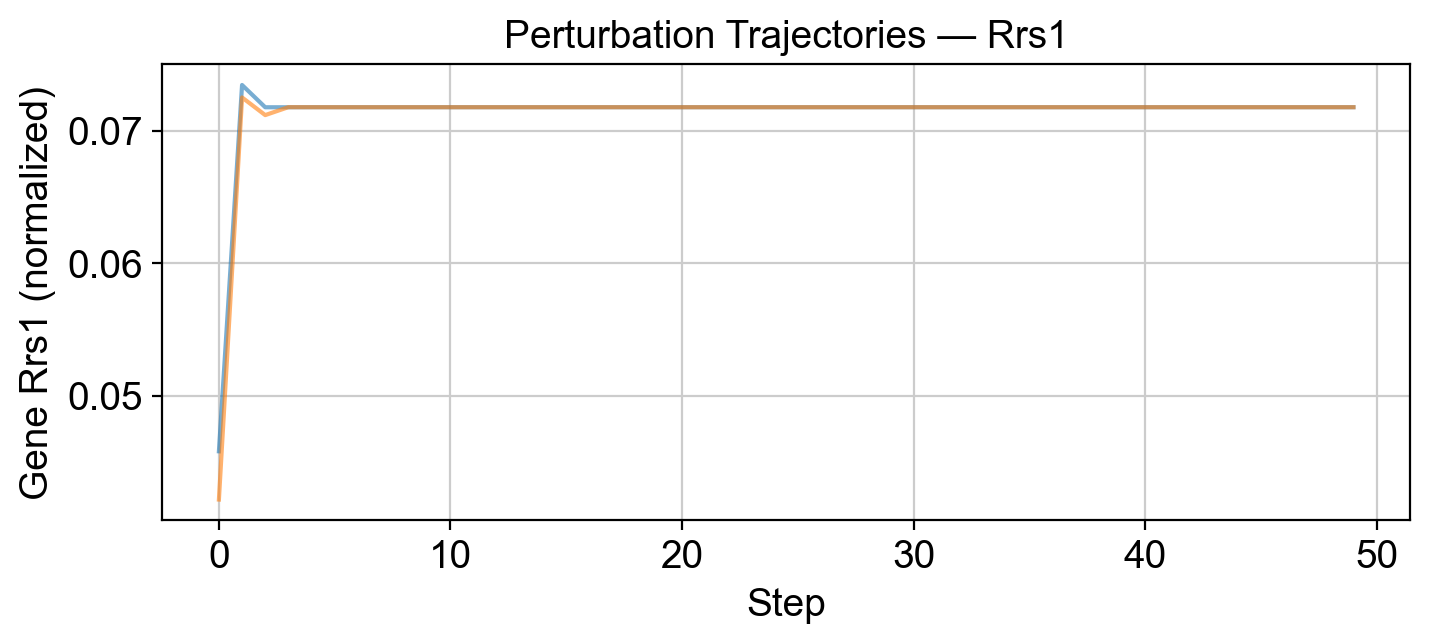


--- Evaluation for Gene 8 (Vcpip1) ---
Accuracy:               0.6600
Precision:              0.6635
Recall:                 0.6600
F1 Score:               0.6615
Final Expression MSE:   1.0413
Final Expression Corr:  0.0839
Trajectory DTW:         7.7724
Trajectory Correlation: nan


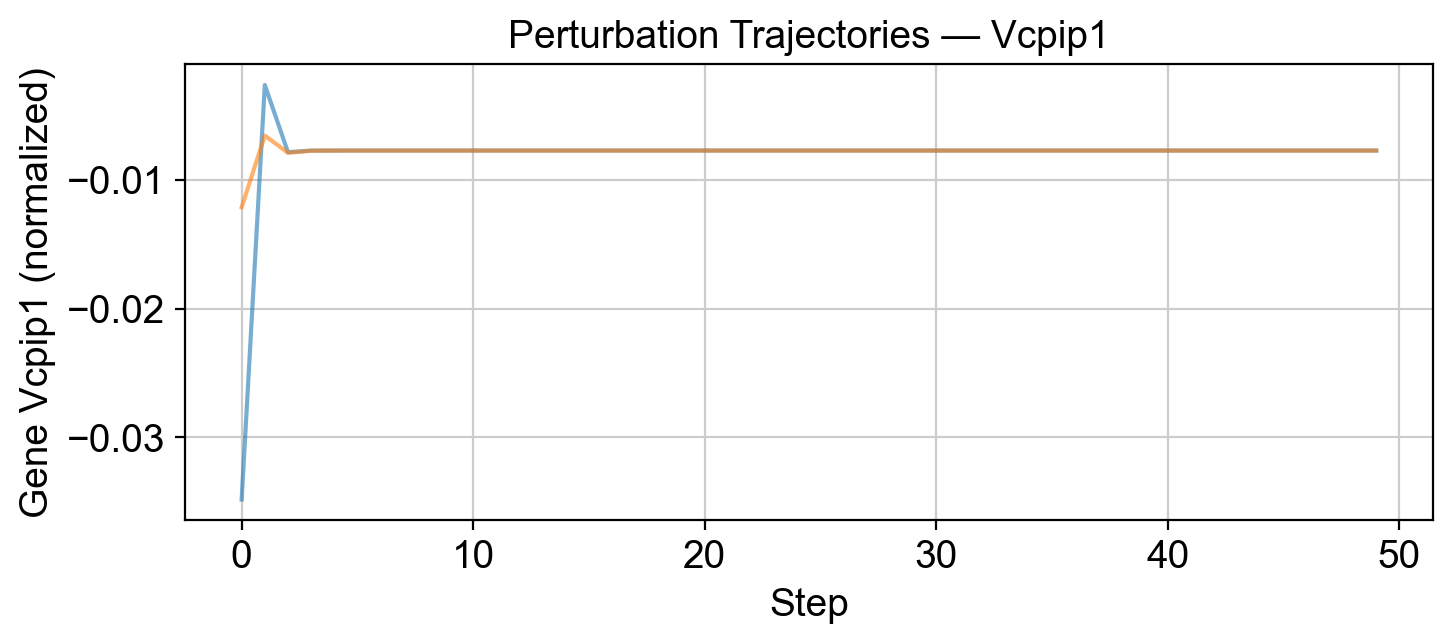


--- Evaluation for Gene 9 (Sgk3) ---
Accuracy:               0.3400
Precision:              0.9465
Recall:                 0.3400
F1 Score:               0.4849
Final Expression MSE:   1.0591
Final Expression Corr:  0.1412
Trajectory DTW:         4.1683
Trajectory Correlation: nan


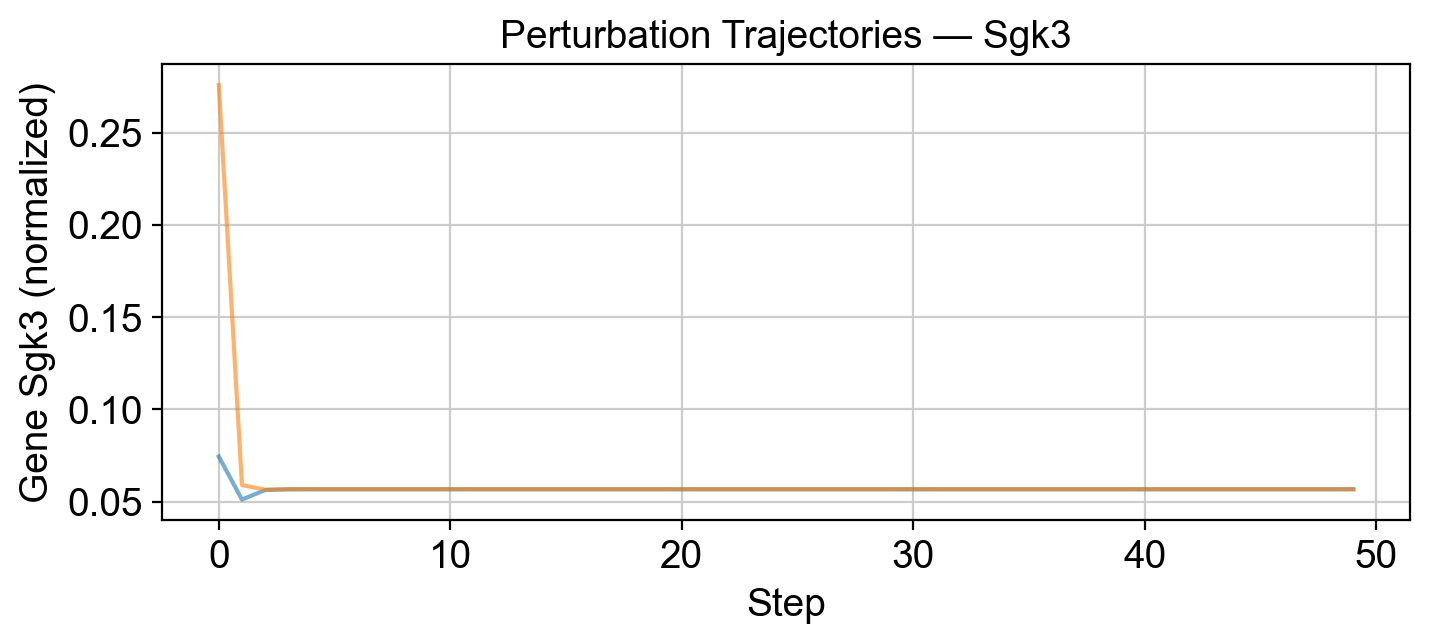


--- Evaluation for Gene 10 (Mcmdc2) ---
Accuracy:               0.4600
Precision:              0.8493
Recall:                 0.4600
F1 Score:               0.5320
Final Expression MSE:   0.9296
Final Expression Corr:  -0.0580
Trajectory DTW:         5.0629
Trajectory Correlation: nan


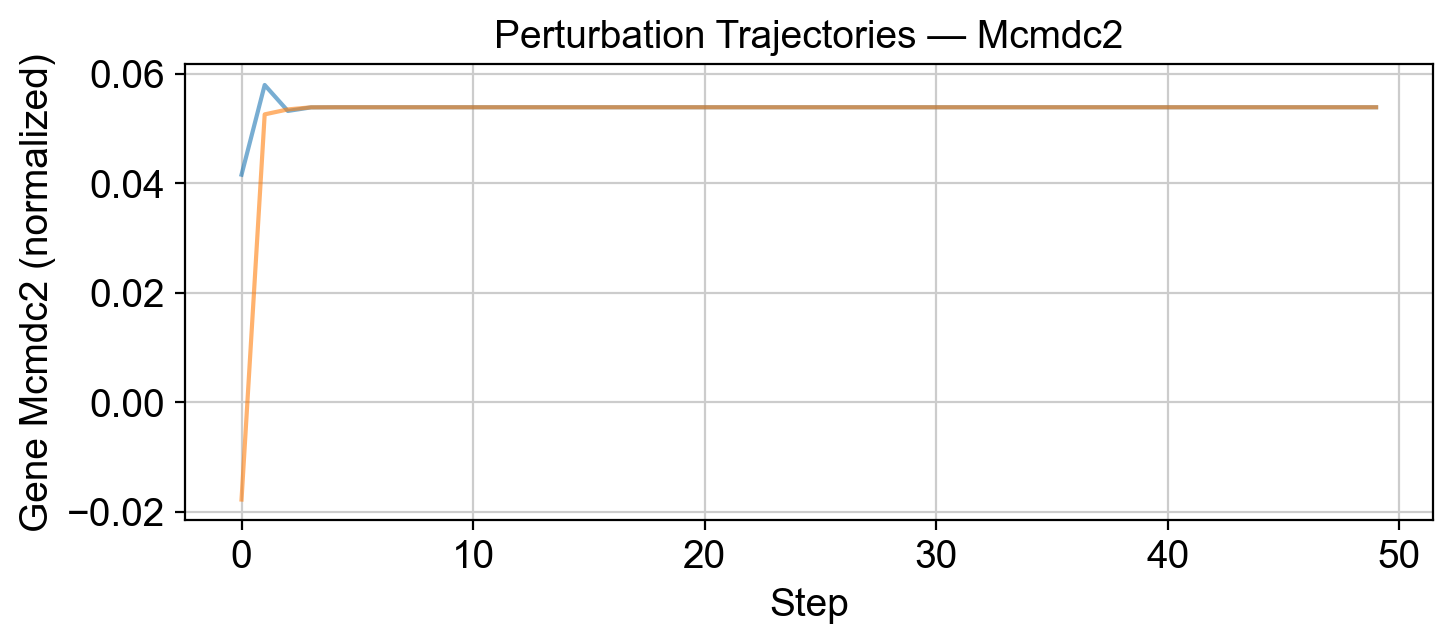


--- Evaluation for Gene 11 (Snhg6) ---
Accuracy:               0.7350
Precision:              0.7599
Recall:                 0.7350
F1 Score:               0.7394
Final Expression MSE:   0.9069
Final Expression Corr:  0.1717
Trajectory DTW:         5.1595
Trajectory Correlation: nan


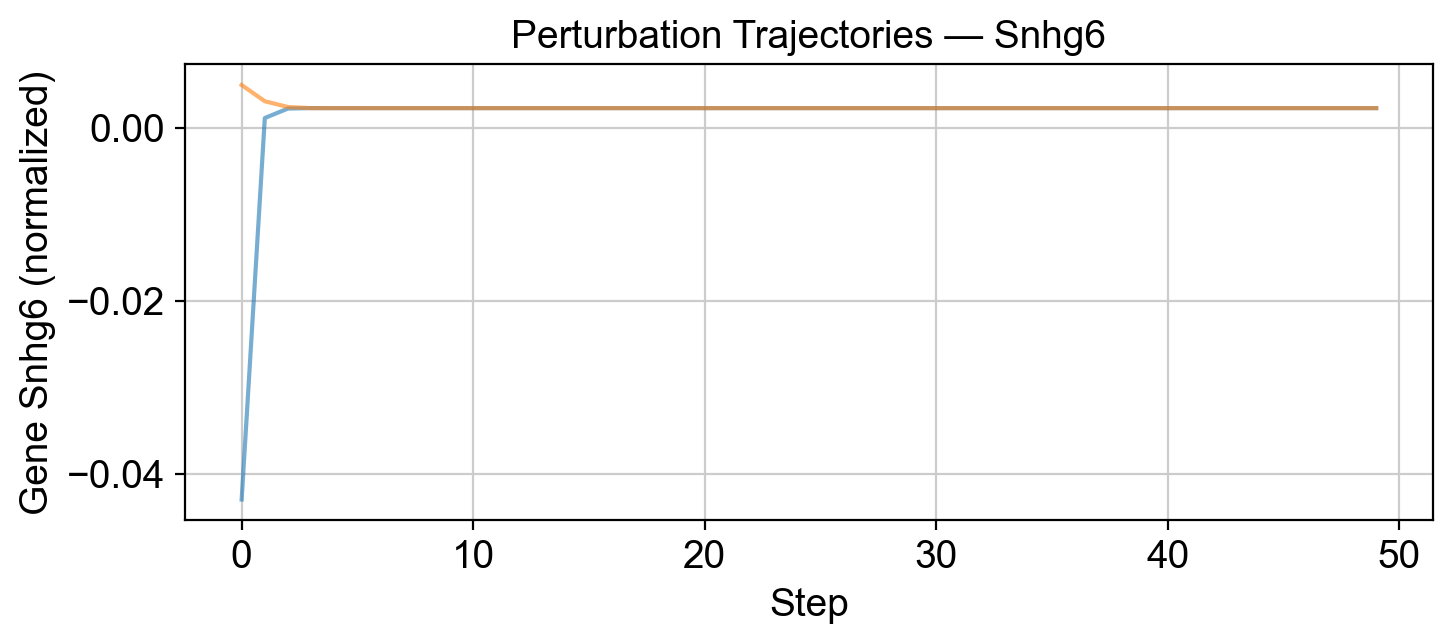


--- Evaluation for Gene 12 (Cops5) ---
Accuracy:               0.4800
Precision:              0.7922
Recall:                 0.4800
F1 Score:               0.5579
Final Expression MSE:   1.0925
Final Expression Corr:  -0.1595
Trajectory DTW:         5.7531
Trajectory Correlation: nan


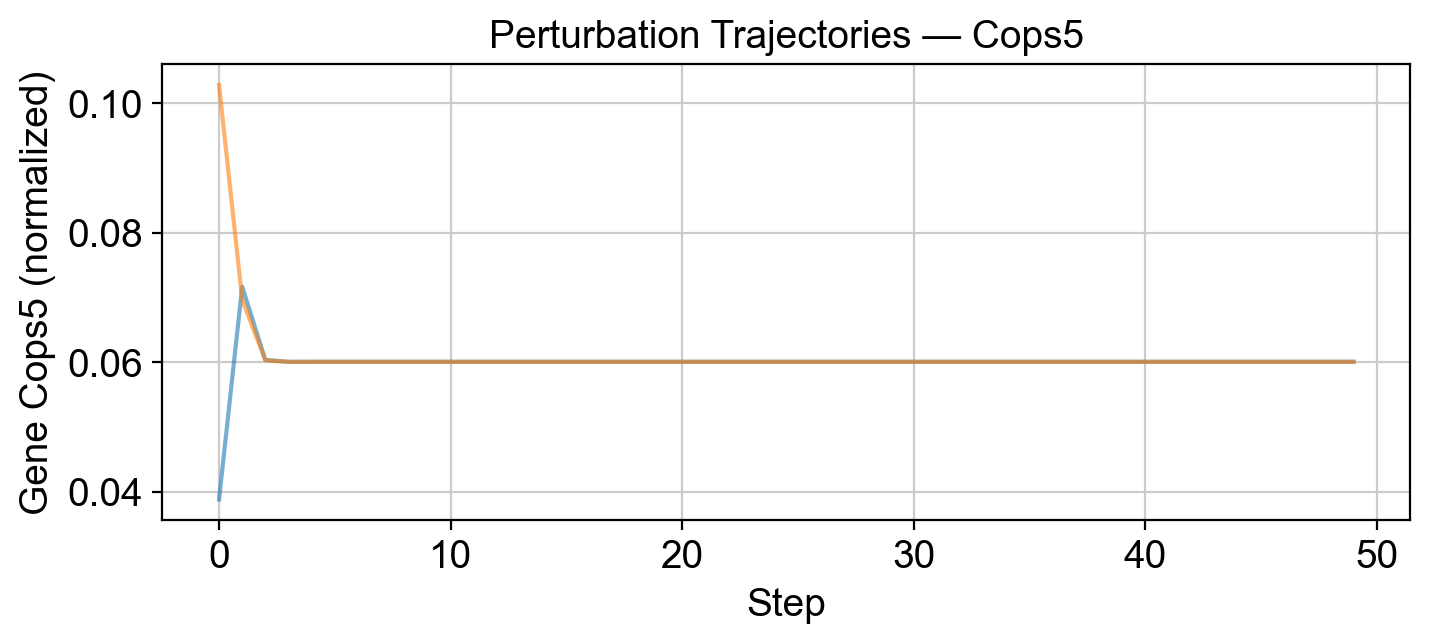


--- Evaluation for Gene 13 (Cspp1) ---
Accuracy:               0.7000
Precision:              0.7681
Recall:                 0.7000
F1 Score:               0.6980
Final Expression MSE:   1.1043
Final Expression Corr:  0.1024
Trajectory DTW:         4.0452
Trajectory Correlation: nan


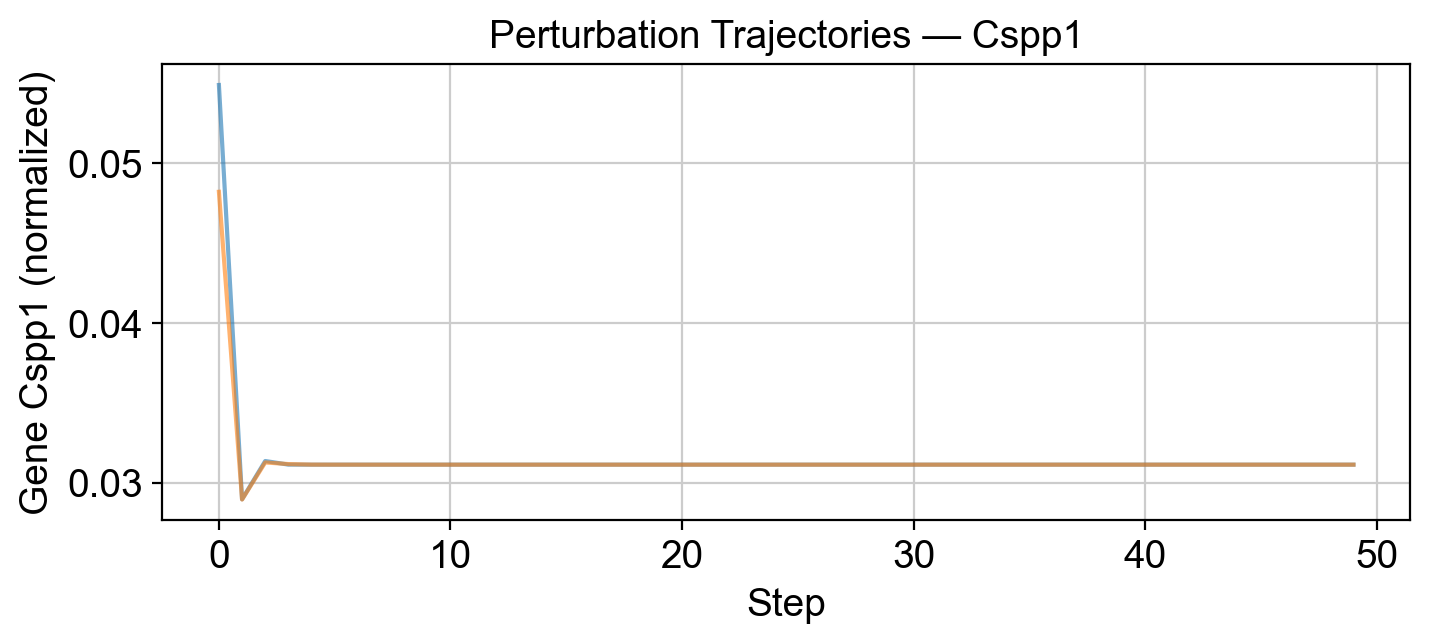


--- Evaluation for Gene 14 (Arfgef1) ---
Accuracy:               0.3900
Precision:              0.7403
Recall:                 0.3900
F1 Score:               0.4353
Final Expression MSE:   0.8892
Final Expression Corr:  -0.0182
Trajectory DTW:         5.1723
Trajectory Correlation: nan


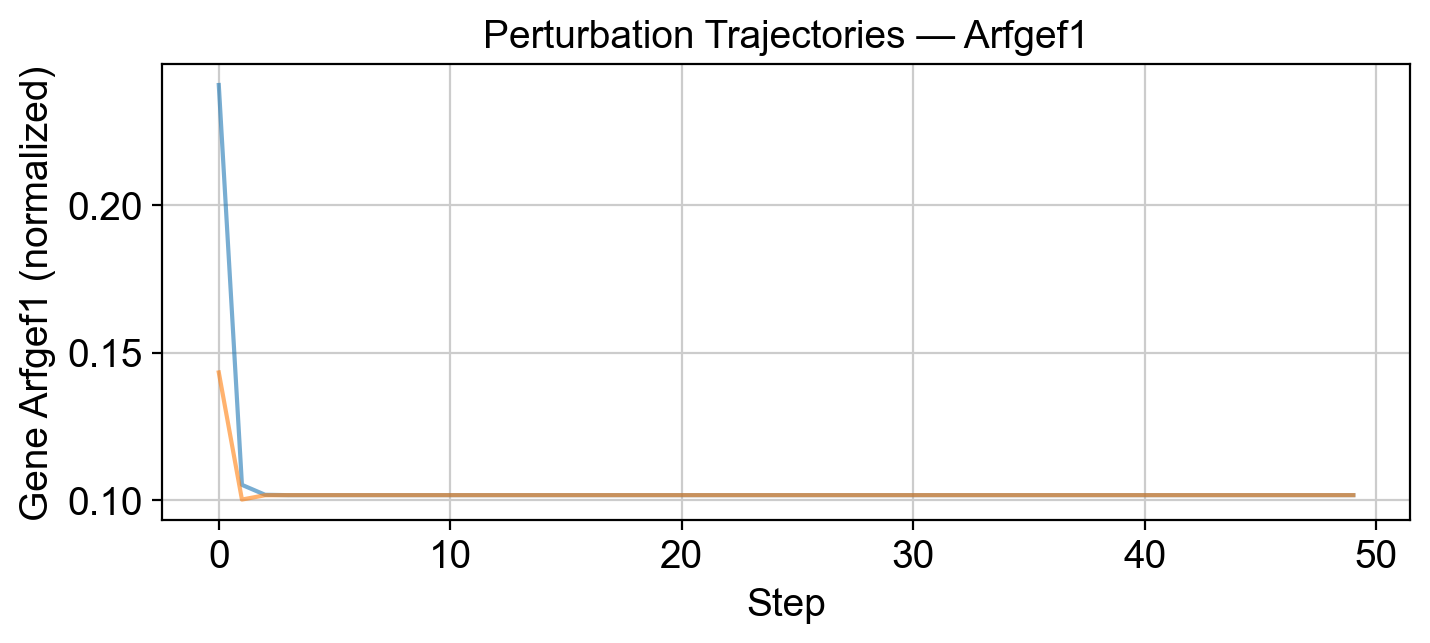


--- Evaluation for Gene 15 (Prex2) ---
Accuracy:               0.6600
Precision:              0.7571
Recall:                 0.6600
F1 Score:               0.6808
Final Expression MSE:   1.0530
Final Expression Corr:  0.2185
Trajectory DTW:         6.9312
Trajectory Correlation: nan


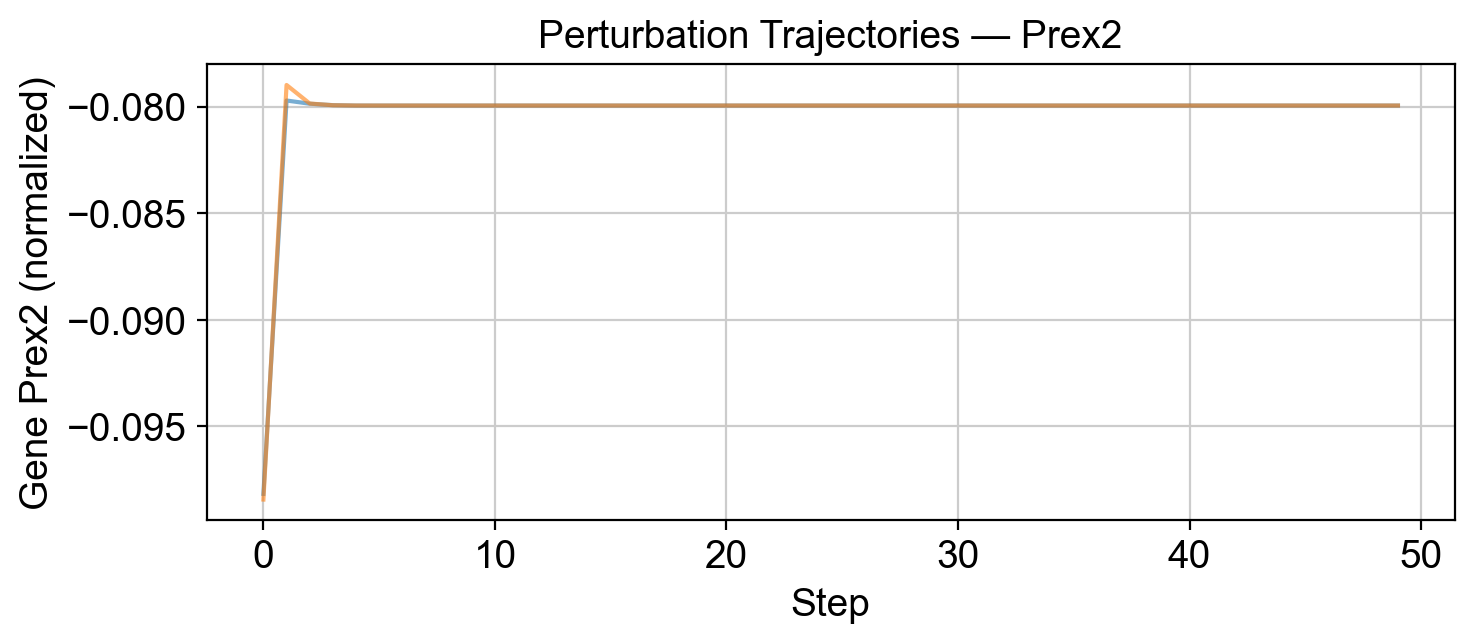


--- Evaluation for Gene 16 (Ncoa2) ---
Accuracy:               0.6600
Precision:              0.7108
Recall:                 0.6600
F1 Score:               0.6637
Final Expression MSE:   1.0106
Final Expression Corr:  0.0499
Trajectory DTW:         5.4633
Trajectory Correlation: nan


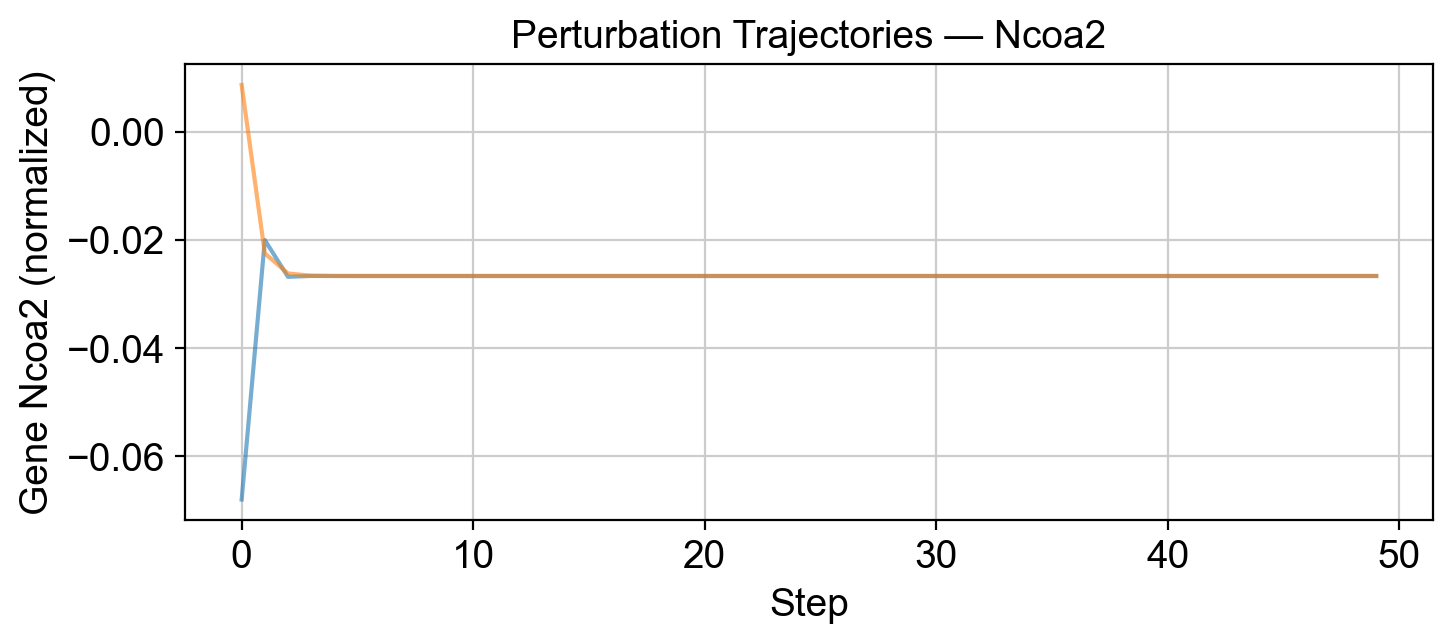


--- Evaluation for Gene 17 (Tram1) ---
Accuracy:               0.6850
Precision:              0.6820
Recall:                 0.6850
F1 Score:               0.6833
Final Expression MSE:   1.0727
Final Expression Corr:  -0.0759
Trajectory DTW:         7.6485
Trajectory Correlation: nan


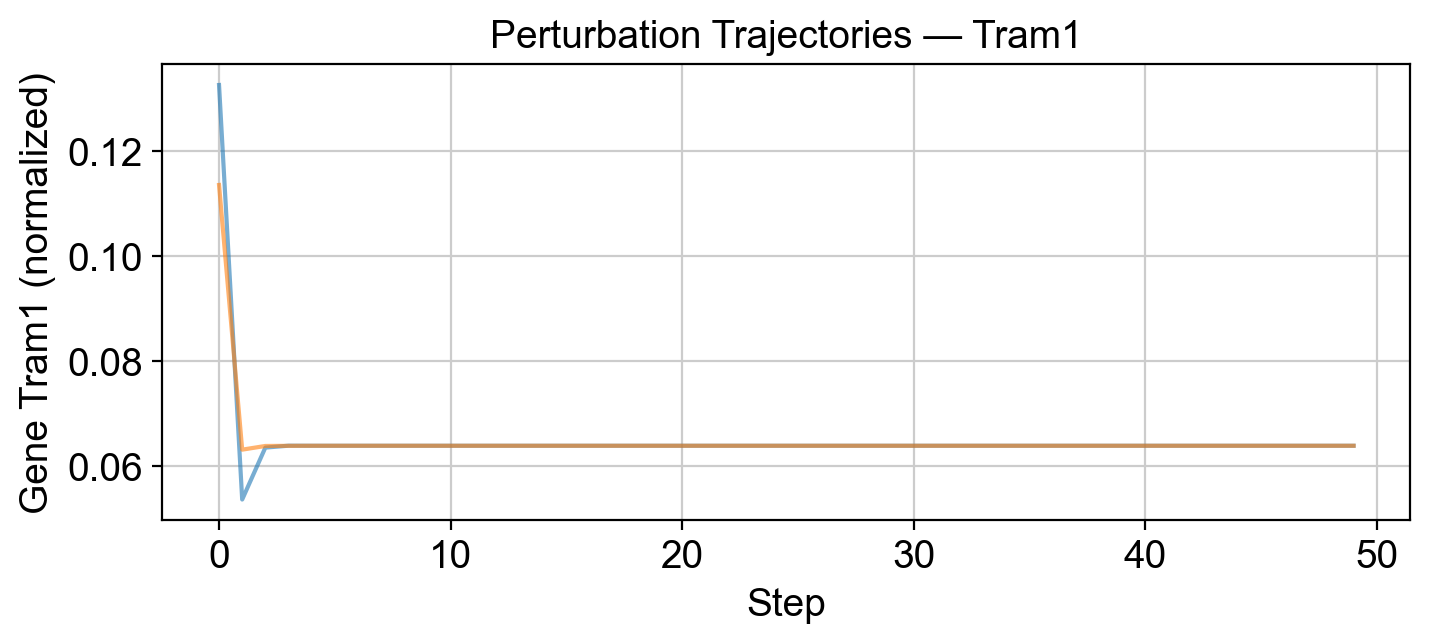


--- Evaluation for Gene 18 (Lactb2) ---
Accuracy:               0.7550
Precision:              0.7994
Recall:                 0.7550
F1 Score:               0.7590
Final Expression MSE:   1.1110
Final Expression Corr:  0.1242
Trajectory DTW:         5.2290
Trajectory Correlation: nan


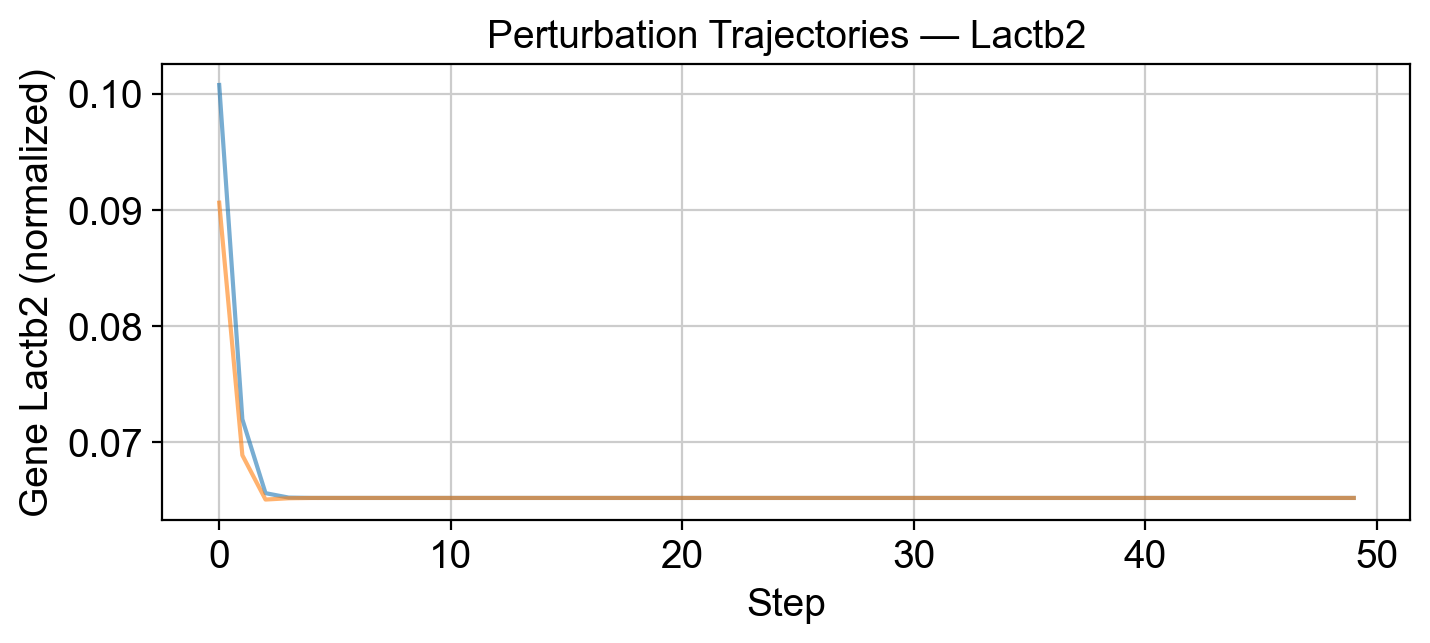


--- Evaluation for Gene 19 (Terf1) ---
Accuracy:               0.6900
Precision:              0.7489
Recall:                 0.6900
F1 Score:               0.6998
Final Expression MSE:   1.1421
Final Expression Corr:  -0.0259
Trajectory DTW:         6.1556
Trajectory Correlation: nan


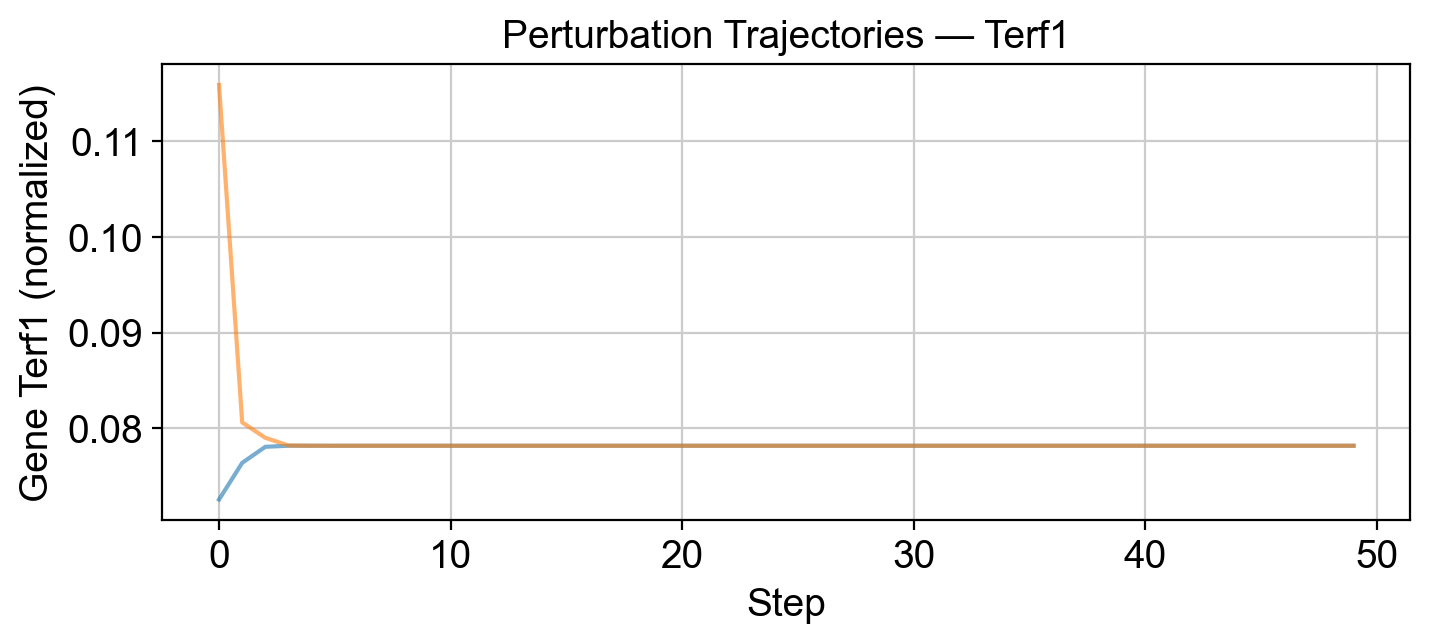

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from dtaidistance import dtw
from scipy.interpolate import interp1d
# from scipy.stats import spearmanr  # Uncomment if you want Spearman correlation alternative

def resample_sequence(seq, target_len):
    seq = np.asarray(seq)
    orig_len = len(seq)
    if orig_len == target_len:
        return seq
    x_old = np.linspace(0, 1, orig_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, seq, kind='linear')
    return f(x_new)

def evaluate_all_genes_updated(
    model,
    expression_test,
    adj_matrix,
    pseudotime_test,
    gene_names,
    edge_index,
    edge_weight,
    encoder_path,
    adaptive_thresholds,
    dynamics_model,
    n_episodes=200
):
    results = {}
    all_perturbed_states = {}
    all_original_states = {}
    all_pseudotimes = []

    eval_env_factory = make_env_factory(expression_test, adj_matrix, pseudotime_test,
                                       edge_index, edge_weight, encoder_path,
                                       adaptive_thresholds, dynamics_model)

    test_env = eval_env_factory()
    reset_result = test_env.reset()
    # Handle whether reset returns tuple or not
    obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    env_state_size = len(test_env.state)

    max_genes = min(len(gene_names), env_state_size)

    for i in range(max_genes):
        all_perturbed_states[i] = []
        all_original_states[i] = []

    all_trajs_pred = {i: [] for i in range(max_genes)}
    all_trajs_true = {i: [] for i in range(max_genes)}

    for gene_idx in range(max_genes):
        y_true, y_pred = [], []

        for ep in range(n_episodes):
            env = eval_env_factory()
            reset_result = env.reset()
            obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result

            original = env.original_state.copy()
            target = env.target.copy()
            pt_value = float(env.pseudotime[env.current_cell])

            done = False
            traj_pred = []

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                step_result = env.step(action)
                if len(step_result) == 5:
                    obs, reward, terminated, truncated, info = step_result
                    done = bool(terminated or truncated)
                else:
                    obs, reward, done, info = step_result

                traj_pred.append(env.state[gene_idx])

            final_state = env.history[-1]
            delta = float(final_state[gene_idx] - original[gene_idx])
            label = 1 if target[gene_idx] > original[gene_idx] else 0
            prediction = 1 if delta > 0 else 0

            y_true.append(label)
            y_pred.append(prediction)

            all_perturbed_states[gene_idx].append(float(final_state[gene_idx]))
            all_original_states[gene_idx].append(float(original[gene_idx]))
            all_pseudotimes.append(pt_value)

            all_trajs_pred[gene_idx].append(np.array(traj_pred))

            if hasattr(env, 'true_trajectory') and env.true_trajectory is not None:
                true_traj_full = np.array(env.true_trajectory)
                true_traj_gene = true_traj_full[:, gene_idx]
                all_trajs_true[gene_idx].append(true_traj_gene)
            else:
                all_trajs_true[gene_idx].append(np.array([target[gene_idx]] * len(traj_pred)))

        # Metrics computation
        acc = accuracy_score(y_true, y_pred) if y_true else 0.0
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0) if y_true else 0.0
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0) if y_true else 0.0
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0) if y_true else 0.0

        mse = mean_squared_error(all_original_states[gene_idx], all_perturbed_states[gene_idx])
        corr = np.corrcoef(all_original_states[gene_idx], all_perturbed_states[gene_idx])[0, 1]

        dtw_distances = []
        traj_corrs = []

        for pred_traj, true_traj in zip(all_trajs_pred[gene_idx], all_trajs_true[gene_idx]):
            pred_traj_1d = np.asarray(pred_traj).flatten()
            true_traj_1d = np.asarray(true_traj).flatten()

            if len(pred_traj_1d) < 2 or len(true_traj_1d) < 2:
                traj_corrs.append(np.nan)
                continue

            target_len = min(len(pred_traj_1d), len(true_traj_1d))
            pred_resampled = resample_sequence(pred_traj_1d, target_len)
            true_resampled = resample_sequence(true_traj_1d, target_len)

            dtw_distances.append(dtw.distance(pred_resampled, true_resampled))

            try:
                if np.std(pred_resampled) == 0 or np.std(true_resampled) == 0:
                    corr_val = np.nan
                else:
                    corr_val = np.corrcoef(pred_resampled, true_resampled)[0, 1]
                # Alternative:
                # corr_val, _ = spearmanr(pred_resampled, true_resampled)
            except Exception:
                corr_val = np.nan

            traj_corrs.append(corr_val)

        avg_dtw = np.mean(dtw_distances) if dtw_distances else None
        avg_traj_corr = np.nanmean(traj_corrs) if traj_corrs else None

        results[gene_idx] = {
            "gene_name": gene_names[gene_idx],
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "final_expression_mse": mse,
            "final_expression_correlation": corr,
            "trajectory_dtw": avg_dtw,
            "trajectory_correlation": avg_traj_corr,
        }

        print(f"\n--- Evaluation for Gene {gene_idx} ({gene_names[gene_idx]}) ---")
        print(f"Accuracy:               {acc:.4f}")
        print(f"Precision:              {prec:.4f}")
        print(f"Recall:                 {rec:.4f}")
        print(f"F1 Score:               {f1:.4f}")
        print(f"Final Expression MSE:   {mse:.4f}")
        print(f"Final Expression Corr:  {corr:.4f}")
        print(f"Trajectory DTW:         {avg_dtw:.4f}" if avg_dtw is not None else "Trajectory DTW: N/A")
        print(f"Trajectory Correlation: {avg_traj_corr:.4f}" if avg_traj_corr is not None else "Trajectory Correlation: N/A")

        plt.figure(figsize=(8, 3))
        for traj in all_trajs_pred[gene_idx][:2]:
            plt.plot(traj, alpha=0.6)
        plt.xlabel("Step")
        plt.ylabel(f"Gene {gene_names[gene_idx]} (normalized)")
        plt.title(f"Perturbation Trajectories — {gene_names[gene_idx]}")
        plt.grid(True)
        plt.show()

    return results, all_perturbed_states, all_original_states, all_pseudotimes


# Usage — **Note** removed redundant ppo_from_trpo param

results, all_perturbed_states, all_original_states, all_pseudotimes = evaluate_all_genes_updated(
    model=ppo_from_trpo,
    expression_test=expression_test,
    adj_matrix=adj_matrix,
    pseudotime_test=pseudotime_test,
    gene_names=gene_names,
    edge_index=edge_index,
    edge_weight=edge_weight,
    encoder_path="gcn_encoder.pth",
    adaptive_thresholds=adaptive_thresholds,
    dynamics_model=dynamics_model,
    n_episodes=200
)
